In [1]:
import re
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
def select_gpu(N):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpus[N], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)    

In [3]:
select_gpu(0)
epochs = 4096
batch_size = 1024
model_name = 'bert-chinese'
embedding_path = '/home/Danny/pretrain_model/{}'.format(model_name)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
3 Physical GPUs, 1 Logical GPUs


In [4]:
# 不用儲存article_id, 轉成list
def training_txt_to_list(path):
    with open(path, 'r') as f:
        txt = str(f.read())
    txt_list = txt.split('\n')
    text_label_list = list()
    tmp = list()
    for line in txt_list:
        if line == '--------------------':
            text_label_list.append(tmp)
            tmp = list()
            continue
        if line == '':
            continue
        tmp.append(line)
    x = list()
    y = list()
    for text_label in text_label_list:
        text = text_label[0]
        label = text_label[2:]
        label_list = ['O' for i in range(len(text))]
        for i in label:
            entity = i.split('\t')
            if int(entity[1]) > int(entity[2]):
                continue
            b = int(entity[1])
            label_list[b] = 'B-{}'.format(entity[-1])
            for j in range(int(entity[1])+1, int(entity[2])):
                label_list[j] = 'I-{}'.format(entity[-1])
        for i, j in enumerate(text):
            if j == '，' or j == '。' or j == '？':
                label_list[i] = j
                
        text_list = re.split('\uff0c|\u3002|\uff1f', text)
        for sentence in text_list:
            x.append([i for i in sentence])
        x = x[:-1]
            
        sentence = list()
        for i in label_list:
            if i == '，' or i == '。' or i == '？':
                y.append(sentence)
                sentence = list()
            else:
                sentence.append(i)
                
    return [x, y]

In [5]:
x1, y1 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage1/SampleData_deid.txt')

In [6]:
x2, y2 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage2/train_1_update.txt')

In [7]:
x4, y4 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage4/train_2.txt')

In [8]:
x = x1 + x2 + x4
y = y1 + y2 + y4
print(len(x))
print(len(y))

76162
76162


In [9]:
df = pd.DataFrame({'x': x, 'y': y})
df

,x,y
0,"[醫, 師, ：, 你, 有, 做, 超, 音, 波, 嘛]","[O, O, O, O, O, O, O, O, O, O]"
1,"[那, 我, 們, 來, 看, 報, 告]","[O, O, O, O, O, O, O]"
2,"[有, 些, 部, 分, 有, 紅, 字, 耶]","[O, O, O, O, O, O, O, O]"
3,"[民, 眾, ：, 紅, 字, 是, 甚, 麼, 意, 思]","[O, O, O, O, O, O, O, O, O, O]"
4,"[醫, 師, ：, 就, 是, 肝, 功, 能, 有, 比, 較, 高]","[O, O, O, O, O, O, O, O, O, O, O, O]"
...,...,...
76157,"[醫, 師, ：, 他, 有, 在, 騎, 腳, 踏, 車]","[O, O, O, O, O, O, O, O, O, O]"
76158,"[民, 眾, ：, 恩]","[O, O, O, O]"
76159,"[醫, 師, ：, 騎, 腳, 踏, 車, 可, 以]","[O, O, O, O, O, O, O, O, O]"
76160,"[小, 美]","[B-name, I-name]"


In [10]:
df['x'] = df['x'].apply(lambda row : str(row))
df['y'] = df['y'].apply(lambda row : str(row))
df = df.drop_duplicates()
df['x'] = df['x'].apply(lambda row : eval(row))
df['y'] = df['y'].apply(lambda row : eval(row))
df

/home/Danny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/Danny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,x,y
0,"[醫, 師, ：, 你, 有, 做, 超, 音, 波, 嘛]","[O, O, O, O, O, O, O, O, O, O]"
1,"[那, 我, 們, 來, 看, 報, 告]","[O, O, O, O, O, O, O]"
2,"[有, 些, 部, 分, 有, 紅, 字, 耶]","[O, O, O, O, O, O, O, O]"
3,"[民, 眾, ：, 紅, 字, 是, 甚, 麼, 意, 思]","[O, O, O, O, O, O, O, O, O, O]"
4,"[醫, 師, ：, 就, 是, 肝, 功, 能, 有, 比, 較, 高]","[O, O, O, O, O, O, O, O, O, O, O, O]"
...,...,...
75713,"[醫, 師, ：, 7, 4, 0, 3]","[O, O, O, B-ID, I-ID, I-ID, I-ID]"
75714,"[醫, 師, ：, 6, 6, 6, 0, 8, 9, 7, 4, 0, 3]","[O, O, O, B-ID, I-ID, I-ID, I-ID, I-ID, I-ID, ..."
75716,"[護, 理, 師, ：, 6, 6, 6, 0, 9, 8]","[O, O, O, O, B-ID, I-ID, I-ID, I-ID, I-ID, I-ID]"
75717,"[醫, 師, ：, 0, 9, 8, 7, 4, 0, 3]","[O, O, O, B-ID, I-ID, I-ID, I-ID, I-ID, I-ID, ..."


In [11]:
x = df['x'].to_list()
y = df['y'].to_list()

In [12]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))
print(len(test_x), len(test_y))

20172 20172
5044 5044
6305 6305


In [13]:
%%time
import kashgari
from kashgari.tasks.labeling import BiLSTM_CRF_Model
from kashgari.embeddings import BertEmbedding
kashgari.config.use_cudnn_cell = True
bert_embedding = BertEmbedding(embedding_path, 
                           sequence_length='auto',
                           trainable=True,
                           task='kashgari.LABELING', 
                          )
model = BiLSTM_CRF_Model(bert_embedding)
history = model.fit(train_x,
                    train_y,
                    valid_x,
                    valid_y,
                    epochs=epochs,
                    batch_size=batch_size,
                   )

2020-12-15 19:50:42,095 [DEBUG] kashgari - ------------------------------------------------
2020-12-15 19:50:42,096 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-15 19:50:42,097 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/bert-chinese/bert_config.json
2020-12-15 19:50:42,097 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/bert-chinese/vocab.txt
2020-12-15 19:50:42,098 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/bert-chinese/bert_model.ckpt
2020-12-15 19:50:42,098 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[

Epoch 1/4096
19/19 [==============================] - 17s 919ms/step - loss: 4.4900 - accuracy: 0.8513 - val_loss: 28.7340 - val_accuracy: 0.9696
Epoch 2/4096
19/19 [==============================] - 13s 698ms/step - loss: 1.2163 - accuracy: 0.9659 - val_loss: 28.6359 - val_accuracy: 0.9716
Epoch 3/4096
19/19 [==============================] - 13s 694ms/step - loss: 0.8308 - accuracy: 0.9709 - val_loss: 28.5179 - val_accuracy: 0.9752
Epoch 4/4096
19/19 [==============================] - 13s 695ms/step - loss: 0.6781 - accuracy: 0.9740 - val_loss: 28.4310 - val_accuracy: 0.9781
Epoch 5/4096
19/19 [==============================] - 13s 696ms/step - loss: 0.5777 - accuracy: 0.9763 - val_loss: 28.4485 - val_accuracy: 0.9793
Epoch 6/4096
19/19 [==============================] - 13s 698ms/step - loss: 0.5138 - accuracy: 0.9778 - val_loss: 28.4729 - val_accuracy: 0.9804
Epoch 7/4096
19/19 [==============================] - 13s 699ms/step - loss: 0.4590 - accuracy: 0.9792 - val_loss: 28.2088 -

Epoch 57/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0632 - accuracy: 0.9965 - val_loss: 27.2404 - val_accuracy: 0.9846
Epoch 58/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0618 - accuracy: 0.9964 - val_loss: 27.2892 - val_accuracy: 0.9846
Epoch 59/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0581 - accuracy: 0.9965 - val_loss: 27.3067 - val_accuracy: 0.9850
Epoch 60/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0583 - accuracy: 0.9965 - val_loss: 27.2309 - val_accuracy: 0.9854
Epoch 61/4096
19/19 [==============================] - 14s 714ms/step - loss: 0.0574 - accuracy: 0.9967 - val_loss: 27.3725 - val_accuracy: 0.9852
Epoch 62/4096
19/19 [==============================] - 14s 714ms/step - loss: 0.0560 - accuracy: 0.9968 - val_loss: 27.1875 - val_accuracy: 0.9851
Epoch 63/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0531 - accuracy: 0.9970 - val_loss: 27

19/19 [==============================] - 13s 705ms/step - loss: 0.0236 - accuracy: 0.9984 - val_loss: 26.6753 - val_accuracy: 0.9831
Epoch 113/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0220 - accuracy: 0.9986 - val_loss: 26.7163 - val_accuracy: 0.9830
Epoch 114/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0224 - accuracy: 0.9987 - val_loss: 26.7960 - val_accuracy: 0.9833
Epoch 115/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0210 - accuracy: 0.9987 - val_loss: 26.7654 - val_accuracy: 0.9833
Epoch 116/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0206 - accuracy: 0.9986 - val_loss: 26.7949 - val_accuracy: 0.9835
Epoch 117/4096
19/19 [==============================] - 13s 707ms/step - loss: 0.0228 - accuracy: 0.9985 - val_loss: 26.7718 - val_accuracy: 0.9837
Epoch 118/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0218 - accuracy: 0.9986 - val_loss: 26.7425 - 

19/19 [==============================] - 13s 703ms/step - loss: 0.0145 - accuracy: 0.9989 - val_loss: 26.3661 - val_accuracy: 0.9817
Epoch 168/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0150 - accuracy: 0.9989 - val_loss: 26.4061 - val_accuracy: 0.9833
Epoch 169/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0157 - accuracy: 0.9987 - val_loss: 26.3445 - val_accuracy: 0.9820
Epoch 170/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0165 - accuracy: 0.9989 - val_loss: 26.3225 - val_accuracy: 0.9810
Epoch 171/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0164 - accuracy: 0.9989 - val_loss: 26.4221 - val_accuracy: 0.9822
Epoch 172/4096
19/19 [==============================] - 14s 720ms/step - loss: 0.0156 - accuracy: 0.9988 - val_loss: 26.3407 - val_accuracy: 0.9821
Epoch 173/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0146 - accuracy: 0.9990 - val_loss: 26.2792 - 

19/19 [==============================] - 14s 713ms/step - loss: 0.0114 - accuracy: 0.9991 - val_loss: 25.9787 - val_accuracy: 0.9705
Epoch 223/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0124 - accuracy: 0.9990 - val_loss: 25.8769 - val_accuracy: 0.9715
Epoch 224/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0150 - accuracy: 0.9987 - val_loss: 26.0021 - val_accuracy: 0.9718
Epoch 225/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0127 - accuracy: 0.9989 - val_loss: 25.8585 - val_accuracy: 0.9723
Epoch 226/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0132 - accuracy: 0.9988 - val_loss: 25.8736 - val_accuracy: 0.9738
Epoch 227/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0110 - accuracy: 0.9989 - val_loss: 25.8863 - val_accuracy: 0.9712
Epoch 228/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0110 - accuracy: 0.9991 - val_loss: 25.8729 - 

19/19 [==============================] - 13s 702ms/step - loss: 0.0099 - accuracy: 0.9990 - val_loss: 25.2673 - val_accuracy: 0.9561
Epoch 278/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0103 - accuracy: 0.9990 - val_loss: 25.5112 - val_accuracy: 0.9549
Epoch 279/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0126 - accuracy: 0.9987 - val_loss: 25.5049 - val_accuracy: 0.9506
Epoch 280/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0114 - accuracy: 0.9989 - val_loss: 25.3656 - val_accuracy: 0.9562
Epoch 281/4096
19/19 [==============================] - 14s 712ms/step - loss: 0.0108 - accuracy: 0.9990 - val_loss: 25.3530 - val_accuracy: 0.9599
Epoch 282/4096
19/19 [==============================] - 14s 714ms/step - loss: 0.0108 - accuracy: 0.9989 - val_loss: 25.4526 - val_accuracy: 0.9629
Epoch 283/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0120 - accuracy: 0.9987 - val_loss: 25.4505 - 

19/19 [==============================] - 13s 703ms/step - loss: 0.0111 - accuracy: 0.9987 - val_loss: 24.7308 - val_accuracy: 0.2571
Epoch 333/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0124 - accuracy: 0.9987 - val_loss: 24.5778 - val_accuracy: 0.2113
Epoch 334/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0115 - accuracy: 0.9989 - val_loss: 24.7681 - val_accuracy: 0.2590
Epoch 335/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0099 - accuracy: 0.9989 - val_loss: 24.6618 - val_accuracy: 0.2043
Epoch 336/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0101 - accuracy: 0.9989 - val_loss: 24.7068 - val_accuracy: 0.1081
Epoch 337/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0114 - accuracy: 0.9987 - val_loss: 24.6348 - val_accuracy: 0.1125
Epoch 338/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0101 - accuracy: 0.9989 - val_loss: 24.6904 - 

19/19 [==============================] - 13s 702ms/step - loss: 0.0069 - accuracy: 0.9990 - val_loss: 24.1209 - val_accuracy: 0.0646
Epoch 388/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0071 - accuracy: 0.9991 - val_loss: 24.1773 - val_accuracy: 0.0642
Epoch 389/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0078 - accuracy: 0.9990 - val_loss: 24.1338 - val_accuracy: 0.0649
Epoch 390/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0079 - accuracy: 0.9991 - val_loss: 24.1684 - val_accuracy: 0.0665
Epoch 391/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0067 - accuracy: 0.9991 - val_loss: 24.1569 - val_accuracy: 0.0632
Epoch 392/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0070 - accuracy: 0.9991 - val_loss: 24.1238 - val_accuracy: 0.0672
Epoch 393/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0065 - accuracy: 0.9991 - val_loss: 24.1465 - 

19/19 [==============================] - 14s 713ms/step - loss: 0.0061 - accuracy: 0.9992 - val_loss: 23.5057 - val_accuracy: 0.0539
Epoch 443/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0069 - accuracy: 0.9989 - val_loss: 23.4995 - val_accuracy: 0.0561
Epoch 444/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0072 - accuracy: 0.9989 - val_loss: 23.4564 - val_accuracy: 0.0545
Epoch 445/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0066 - accuracy: 0.9991 - val_loss: 23.4526 - val_accuracy: 0.0500
Epoch 446/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0062 - accuracy: 0.9990 - val_loss: 23.4787 - val_accuracy: 0.0526
Epoch 447/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0057 - accuracy: 0.9993 - val_loss: 23.4608 - val_accuracy: 0.0518
Epoch 448/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0061 - accuracy: 0.9990 - val_loss: 23.4414 - 

19/19 [==============================] - 13s 701ms/step - loss: 0.0065 - accuracy: 0.9989 - val_loss: 22.7826 - val_accuracy: 0.0420
Epoch 498/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0064 - accuracy: 0.9991 - val_loss: 22.8650 - val_accuracy: 0.0428
Epoch 499/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0066 - accuracy: 0.9990 - val_loss: 22.7569 - val_accuracy: 0.0434
Epoch 500/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0060 - accuracy: 0.9990 - val_loss: 22.6928 - val_accuracy: 0.0431
Epoch 501/4096
19/19 [==============================] - 14s 713ms/step - loss: 0.0062 - accuracy: 0.9991 - val_loss: 22.8551 - val_accuracy: 0.0427
Epoch 502/4096
19/19 [==============================] - 14s 713ms/step - loss: 0.0058 - accuracy: 0.9990 - val_loss: 22.8506 - val_accuracy: 0.0403
Epoch 503/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0064 - accuracy: 0.9991 - val_loss: 22.8894 - 

19/19 [==============================] - 13s 705ms/step - loss: 0.0050 - accuracy: 0.9992 - val_loss: 22.1217 - val_accuracy: 0.0293
Epoch 553/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0058 - accuracy: 0.9991 - val_loss: 22.1858 - val_accuracy: 0.0289
Epoch 554/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0061 - accuracy: 0.9991 - val_loss: 22.1801 - val_accuracy: 0.0316
Epoch 555/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0056 - accuracy: 0.9990 - val_loss: 22.2093 - val_accuracy: 0.0309
Epoch 556/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0053 - accuracy: 0.9991 - val_loss: 22.1427 - val_accuracy: 0.0295
Epoch 557/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0053 - accuracy: 0.9992 - val_loss: 22.2786 - val_accuracy: 0.0294
Epoch 558/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0058 - accuracy: 0.9990 - val_loss: 22.1231 - 

19/19 [==============================] - 13s 703ms/step - loss: 0.0057 - accuracy: 0.9991 - val_loss: 21.6899 - val_accuracy: 0.0226
Epoch 608/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0055 - accuracy: 0.9991 - val_loss: 21.7076 - val_accuracy: 0.0214
Epoch 609/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0052 - accuracy: 0.9991 - val_loss: 21.6544 - val_accuracy: 0.0215
Epoch 610/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0065 - accuracy: 0.9990 - val_loss: 21.6122 - val_accuracy: 0.0214
Epoch 611/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0051 - accuracy: 0.9991 - val_loss: 21.7149 - val_accuracy: 0.0211
Epoch 612/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0054 - accuracy: 0.9991 - val_loss: 21.6095 - val_accuracy: 0.0215
Epoch 613/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0049 - accuracy: 0.9991 - val_loss: 21.6198 - 

19/19 [==============================] - 14s 713ms/step - loss: 0.0058 - accuracy: 0.9990 - val_loss: 21.2280 - val_accuracy: 0.0164
Epoch 663/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0062 - accuracy: 0.9990 - val_loss: 21.2181 - val_accuracy: 0.0143
Epoch 664/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0061 - accuracy: 0.9989 - val_loss: 21.1547 - val_accuracy: 0.0153
Epoch 665/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0056 - accuracy: 0.9991 - val_loss: 21.1887 - val_accuracy: 0.0148
Epoch 666/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0055 - accuracy: 0.9991 - val_loss: 21.2724 - val_accuracy: 0.0149
Epoch 667/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0053 - accuracy: 0.9991 - val_loss: 21.2228 - val_accuracy: 0.0158
Epoch 668/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0057 - accuracy: 0.9990 - val_loss: 21.2047 - 

19/19 [==============================] - 13s 703ms/step - loss: 0.0047 - accuracy: 0.9992 - val_loss: 20.7683 - val_accuracy: 0.0109
Epoch 718/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0049 - accuracy: 0.9991 - val_loss: 20.8454 - val_accuracy: 0.0127
Epoch 719/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0053 - accuracy: 0.9991 - val_loss: 20.7532 - val_accuracy: 0.0134
Epoch 720/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0056 - accuracy: 0.9991 - val_loss: 20.7800 - val_accuracy: 0.0122
Epoch 721/4096
19/19 [==============================] - 14s 712ms/step - loss: 0.0052 - accuracy: 0.9991 - val_loss: 20.7459 - val_accuracy: 0.0110
Epoch 722/4096
19/19 [==============================] - 14s 713ms/step - loss: 0.0051 - accuracy: 0.9991 - val_loss: 20.7054 - val_accuracy: 0.0121
Epoch 723/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0057 - accuracy: 0.9990 - val_loss: 20.7187 - 

19/19 [==============================] - 13s 702ms/step - loss: 0.0046 - accuracy: 0.9992 - val_loss: 20.4653 - val_accuracy: 0.0112
Epoch 773/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0042 - accuracy: 0.9993 - val_loss: 20.4945 - val_accuracy: 0.0112
Epoch 774/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0047 - accuracy: 0.9990 - val_loss: 20.4857 - val_accuracy: 0.0115
Epoch 775/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0041 - accuracy: 0.9993 - val_loss: 20.4447 - val_accuracy: 0.0121
Epoch 776/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0053 - accuracy: 0.9990 - val_loss: 20.4583 - val_accuracy: 0.0118
Epoch 777/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0055 - accuracy: 0.9990 - val_loss: 20.4811 - val_accuracy: 0.0109
Epoch 778/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0061 - accuracy: 0.9990 - val_loss: 20.4164 - 

19/19 [==============================] - 13s 703ms/step - loss: 0.0053 - accuracy: 0.9990 - val_loss: 20.0148 - val_accuracy: 0.0098
Epoch 828/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0048 - accuracy: 0.9991 - val_loss: 20.1212 - val_accuracy: 0.0093
Epoch 829/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0051 - accuracy: 0.9991 - val_loss: 20.0114 - val_accuracy: 0.0098
Epoch 830/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0056 - accuracy: 0.9990 - val_loss: 20.0959 - val_accuracy: 0.0107
Epoch 831/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0052 - accuracy: 0.9990 - val_loss: 20.1179 - val_accuracy: 0.0100
Epoch 832/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0056 - accuracy: 0.9991 - val_loss: 20.1182 - val_accuracy: 0.0108
Epoch 833/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0044 - accuracy: 0.9992 - val_loss: 19.9706 - 

19/19 [==============================] - 14s 712ms/step - loss: 0.0048 - accuracy: 0.9991 - val_loss: 19.7918 - val_accuracy: 0.0087
Epoch 883/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0048 - accuracy: 0.9991 - val_loss: 19.8286 - val_accuracy: 0.0082
Epoch 884/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0047 - accuracy: 0.9991 - val_loss: 19.7478 - val_accuracy: 0.0082
Epoch 885/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0043 - accuracy: 0.9992 - val_loss: 19.7563 - val_accuracy: 0.0091
Epoch 886/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0046 - accuracy: 0.9991 - val_loss: 19.7682 - val_accuracy: 0.0091
Epoch 887/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 19.7432 - val_accuracy: 0.0086
Epoch 888/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0046 - accuracy: 0.9990 - val_loss: 19.7652 - 

19/19 [==============================] - 13s 703ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 19.5894 - val_accuracy: 0.0077
Epoch 938/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 19.6263 - val_accuracy: 0.0069
Epoch 939/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0042 - accuracy: 0.9992 - val_loss: 19.6545 - val_accuracy: 0.0070
Epoch 940/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0046 - accuracy: 0.9991 - val_loss: 19.6546 - val_accuracy: 0.0072
Epoch 941/4096
19/19 [==============================] - 14s 713ms/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 19.6761 - val_accuracy: 0.0065
Epoch 942/4096
19/19 [==============================] - 14s 713ms/step - loss: 0.0047 - accuracy: 0.9992 - val_loss: 19.7080 - val_accuracy: 0.0069
Epoch 943/4096
19/19 [==============================] - 14s 727ms/step - loss: 0.0042 - accuracy: 0.9992 - val_loss: 19.5450 - 

19/19 [==============================] - 13s 704ms/step - loss: 0.0048 - accuracy: 0.9990 - val_loss: 19.5529 - val_accuracy: 0.0052
Epoch 993/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0046 - accuracy: 0.9992 - val_loss: 19.4710 - val_accuracy: 0.0057
Epoch 994/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0051 - accuracy: 0.9991 - val_loss: 19.4141 - val_accuracy: 0.0060
Epoch 995/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0053 - accuracy: 0.9991 - val_loss: 19.4367 - val_accuracy: 0.0070
Epoch 996/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0047 - accuracy: 0.9990 - val_loss: 19.4607 - val_accuracy: 0.0052
Epoch 997/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0046 - accuracy: 0.9991 - val_loss: 19.4174 - val_accuracy: 0.0065
Epoch 998/4096
19/19 [==============================] - 13s 701ms/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 19.4286 - 

19/19 [==============================] - 13s 704ms/step - loss: 0.0043 - accuracy: 0.9992 - val_loss: 19.2803 - val_accuracy: 0.0054
Epoch 1048/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 19.1858 - val_accuracy: 0.0061
Epoch 1049/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0040 - accuracy: 0.9991 - val_loss: 19.2492 - val_accuracy: 0.0057
Epoch 1050/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 19.2369 - val_accuracy: 0.0059
Epoch 1051/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0042 - accuracy: 0.9992 - val_loss: 19.2372 - val_accuracy: 0.0050
Epoch 1052/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 19.2133 - val_accuracy: 0.0057
Epoch 1053/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0040 - accuracy: 0.9992 - val_loss: 19.2

19/19 [==============================] - 14s 713ms/step - loss: 0.0043 - accuracy: 0.9992 - val_loss: 19.1232 - val_accuracy: 0.0057
Epoch 1103/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0043 - accuracy: 0.9992 - val_loss: 19.1048 - val_accuracy: 0.0055
Epoch 1104/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 19.1448 - val_accuracy: 0.0055
Epoch 1105/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0044 - accuracy: 0.9992 - val_loss: 19.0837 - val_accuracy: 0.0053
Epoch 1106/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0039 - accuracy: 0.9993 - val_loss: 19.0210 - val_accuracy: 0.0052
Epoch 1107/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0048 - accuracy: 0.9991 - val_loss: 19.1602 - val_accuracy: 0.0050
Epoch 1108/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0043 - accuracy: 0.9992 - val_loss: 19.1

19/19 [==============================] - 13s 704ms/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 18.9496 - val_accuracy: 0.0043
Epoch 1158/4096
19/19 [==============================] - 13s 701ms/step - loss: 0.0051 - accuracy: 0.9990 - val_loss: 18.9812 - val_accuracy: 0.0054
Epoch 1159/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0051 - accuracy: 0.9989 - val_loss: 19.0301 - val_accuracy: 0.0049
Epoch 1160/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0040 - accuracy: 0.9992 - val_loss: 19.0700 - val_accuracy: 0.0047
Epoch 1161/4096
19/19 [==============================] - 14s 714ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 19.0299 - val_accuracy: 0.0046
Epoch 1162/4096
19/19 [==============================] - 14s 713ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 19.0732 - val_accuracy: 0.0050
Epoch 1163/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 18.9

19/19 [==============================] - 13s 703ms/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 18.9613 - val_accuracy: 0.0036
Epoch 1213/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 18.9113 - val_accuracy: 0.0037
Epoch 1214/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0043 - accuracy: 0.9991 - val_loss: 18.8461 - val_accuracy: 0.0043
Epoch 1215/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 18.8562 - val_accuracy: 0.0039
Epoch 1216/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0050 - accuracy: 0.9991 - val_loss: 18.8508 - val_accuracy: 0.0042
Epoch 1217/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0049 - accuracy: 0.9990 - val_loss: 18.9783 - val_accuracy: 0.0043
Epoch 1218/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0051 - accuracy: 0.9990 - val_loss: 18.9

19/19 [==============================] - 13s 704ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 18.8158 - val_accuracy: 0.0034
Epoch 1268/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 18.8398 - val_accuracy: 0.0032
Epoch 1269/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0040 - accuracy: 0.9991 - val_loss: 18.8064 - val_accuracy: 0.0033
Epoch 1270/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 18.8362 - val_accuracy: 0.0031
Epoch 1271/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 18.8746 - val_accuracy: 0.0033
Epoch 1272/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 18.8016 - val_accuracy: 0.0038
Epoch 1273/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 18.8

19/19 [==============================] - 14s 713ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 18.7716 - val_accuracy: 0.0036
Epoch 1323/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 18.7545 - val_accuracy: 0.0033
Epoch 1324/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 18.7936 - val_accuracy: 0.0031
Epoch 1325/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0048 - accuracy: 0.9990 - val_loss: 18.7318 - val_accuracy: 0.0035
Epoch 1326/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 18.7791 - val_accuracy: 0.0033
Epoch 1327/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0053 - accuracy: 0.9992 - val_loss: 18.7022 - val_accuracy: 0.0033
Epoch 1328/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0038 - accuracy: 0.9993 - val_loss: 18.7

19/19 [==============================] - 13s 703ms/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 18.6326 - val_accuracy: 0.0033
Epoch 1378/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0038 - accuracy: 0.9993 - val_loss: 18.6577 - val_accuracy: 0.0029
Epoch 1379/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0043 - accuracy: 0.9991 - val_loss: 18.6973 - val_accuracy: 0.0029
Epoch 1380/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 18.5877 - val_accuracy: 0.0030
Epoch 1381/4096
19/19 [==============================] - 14s 712ms/step - loss: 0.0045 - accuracy: 0.9992 - val_loss: 18.6143 - val_accuracy: 0.0031
Epoch 1382/4096
19/19 [==============================] - 14s 712ms/step - loss: 0.0042 - accuracy: 0.9992 - val_loss: 18.5726 - val_accuracy: 0.0032
Epoch 1383/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0047 - accuracy: 0.9990 - val_loss: 18.5

19/19 [==============================] - 13s 702ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 18.4555 - val_accuracy: 0.0031
Epoch 1433/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0055 - accuracy: 0.9990 - val_loss: 18.5478 - val_accuracy: 0.0030
Epoch 1434/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 18.4553 - val_accuracy: 0.0034
Epoch 1435/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0046 - accuracy: 0.9992 - val_loss: 18.4610 - val_accuracy: 0.0025
Epoch 1436/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 18.4629 - val_accuracy: 0.0025
Epoch 1437/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0047 - accuracy: 0.9990 - val_loss: 18.4717 - val_accuracy: 0.0024
Epoch 1438/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0048 - accuracy: 0.9991 - val_loss: 18.4

19/19 [==============================] - 13s 704ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 18.4669 - val_accuracy: 0.0023
Epoch 1488/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 18.4096 - val_accuracy: 0.0018
Epoch 1489/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 18.4310 - val_accuracy: 0.0024
Epoch 1490/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 18.4247 - val_accuracy: 0.0023
Epoch 1491/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 18.4271 - val_accuracy: 0.0019
Epoch 1492/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0040 - accuracy: 0.9992 - val_loss: 18.4145 - val_accuracy: 0.0024
Epoch 1493/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 18.3

19/19 [==============================] - 14s 713ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 18.3557 - val_accuracy: 0.0019
Epoch 1543/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 18.3941 - val_accuracy: 0.0019
Epoch 1544/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0046 - accuracy: 0.9991 - val_loss: 18.3496 - val_accuracy: 0.0020
Epoch 1545/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 18.3667 - val_accuracy: 0.0020
Epoch 1546/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 18.4267 - val_accuracy: 0.0019
Epoch 1547/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 18.3276 - val_accuracy: 0.0022
Epoch 1548/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0043 - accuracy: 0.9992 - val_loss: 18.3

19/19 [==============================] - 13s 704ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 18.3395 - val_accuracy: 0.0022
Epoch 1598/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0046 - accuracy: 0.9991 - val_loss: 18.2966 - val_accuracy: 0.0018
Epoch 1599/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 18.3307 - val_accuracy: 0.0022
Epoch 1600/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0044 - accuracy: 0.9992 - val_loss: 18.3211 - val_accuracy: 0.0021
Epoch 1601/4096
19/19 [==============================] - 14s 715ms/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 18.3708 - val_accuracy: 0.0021
Epoch 1602/4096
19/19 [==============================] - 14s 714ms/step - loss: 0.0048 - accuracy: 0.9992 - val_loss: 18.2897 - val_accuracy: 0.0023
Epoch 1603/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 18.3

19/19 [==============================] - 13s 703ms/step - loss: 0.0044 - accuracy: 0.9990 - val_loss: 18.2892 - val_accuracy: 0.0018
Epoch 1653/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 18.2580 - val_accuracy: 0.0021
Epoch 1654/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 18.3247 - val_accuracy: 0.0015
Epoch 1655/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 18.2798 - val_accuracy: 0.0018
Epoch 1656/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 18.3070 - val_accuracy: 0.0018
Epoch 1657/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 18.2303 - val_accuracy: 0.0021
Epoch 1658/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 18.3

19/19 [==============================] - 13s 703ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 18.3137 - val_accuracy: 0.0017
Epoch 1708/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 18.3785 - val_accuracy: 0.0016
Epoch 1709/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0044 - accuracy: 0.9990 - val_loss: 18.3309 - val_accuracy: 0.0016
Epoch 1710/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 18.3555 - val_accuracy: 0.0016
Epoch 1711/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 18.3133 - val_accuracy: 0.0018
Epoch 1712/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 18.3250 - val_accuracy: 0.0018
Epoch 1713/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0039 - accuracy: 0.9993 - val_loss: 18.2

19/19 [==============================] - 14s 714ms/step - loss: 0.0037 - accuracy: 0.9990 - val_loss: 18.2915 - val_accuracy: 0.0016
Epoch 1763/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 18.2578 - val_accuracy: 0.0016
Epoch 1764/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 18.2907 - val_accuracy: 0.0015
Epoch 1765/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 18.3081 - val_accuracy: 0.0015
Epoch 1766/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 18.2560 - val_accuracy: 0.0013
Epoch 1767/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 18.2347 - val_accuracy: 0.0017
Epoch 1768/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 18.1

19/19 [==============================] - 13s 703ms/step - loss: 0.0040 - accuracy: 0.9991 - val_loss: 18.2169 - val_accuracy: 0.0016
Epoch 1818/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 18.2486 - val_accuracy: 0.0012
Epoch 1819/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 18.2141 - val_accuracy: 0.0014
Epoch 1820/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 18.3203 - val_accuracy: 0.0016
Epoch 1821/4096
19/19 [==============================] - 14s 713ms/step - loss: 0.0040 - accuracy: 0.9991 - val_loss: 18.1777 - val_accuracy: 0.0014
Epoch 1822/4096
19/19 [==============================] - 14s 713ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 18.2831 - val_accuracy: 0.0012
Epoch 1823/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 18.1

19/19 [==============================] - 13s 704ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 18.2480 - val_accuracy: 0.0017
Epoch 1873/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 18.1915 - val_accuracy: 0.0014
Epoch 1874/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 18.1326 - val_accuracy: 0.0013
Epoch 1875/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 18.1132 - val_accuracy: 0.0014
Epoch 1876/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 18.1879 - val_accuracy: 0.0017
Epoch 1877/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 18.1524 - val_accuracy: 0.0016
Epoch 1878/4096
19/19 [==============================] - 13s 706ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 18.1

19/19 [==============================] - 13s 702ms/step - loss: 0.0044 - accuracy: 0.9992 - val_loss: 18.0779 - val_accuracy: 0.0013
Epoch 1928/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0043 - accuracy: 0.9991 - val_loss: 18.1447 - val_accuracy: 0.0014
Epoch 1929/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0046 - accuracy: 0.9990 - val_loss: 18.1226 - val_accuracy: 0.0015
Epoch 1930/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 18.1285 - val_accuracy: 0.0016
Epoch 1931/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 18.0633 - val_accuracy: 0.0014
Epoch 1932/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 18.1261 - val_accuracy: 0.0018
Epoch 1933/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 18.1

19/19 [==============================] - 14s 712ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 18.1622 - val_accuracy: 0.0015
Epoch 1983/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0043 - accuracy: 0.9992 - val_loss: 18.1153 - val_accuracy: 0.0013
Epoch 1984/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0047 - accuracy: 0.9990 - val_loss: 18.0541 - val_accuracy: 0.0014
Epoch 1985/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 18.1230 - val_accuracy: 0.0015
Epoch 1986/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 18.0746 - val_accuracy: 0.0016
Epoch 1987/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0040 - accuracy: 0.9991 - val_loss: 18.0964 - val_accuracy: 0.0015
Epoch 1988/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 18.0

19/19 [==============================] - 13s 703ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 18.0140 - val_accuracy: 0.0013
Epoch 2038/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0048 - accuracy: 0.9989 - val_loss: 17.9473 - val_accuracy: 0.0015
Epoch 2039/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0044 - accuracy: 0.9990 - val_loss: 18.0115 - val_accuracy: 0.0015
Epoch 2040/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0040 - accuracy: 0.9991 - val_loss: 18.0926 - val_accuracy: 0.0014
Epoch 2041/4096
19/19 [==============================] - 14s 712ms/step - loss: 0.0047 - accuracy: 0.9991 - val_loss: 18.0166 - val_accuracy: 0.0018
Epoch 2042/4096
19/19 [==============================] - 14s 712ms/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 18.0347 - val_accuracy: 0.0018
Epoch 2043/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 18.0

19/19 [==============================] - 13s 703ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 18.0154 - val_accuracy: 0.0015
Epoch 2093/4096
19/19 [==============================] - 13s 707ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 17.9737 - val_accuracy: 0.0015
Epoch 2094/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 17.9959 - val_accuracy: 0.0014
Epoch 2095/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 18.1528 - val_accuracy: 0.0015
Epoch 2096/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 18.0866 - val_accuracy: 0.0015
Epoch 2097/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0040 - accuracy: 0.9992 - val_loss: 18.1286 - val_accuracy: 0.0016
Epoch 2098/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0042 - accuracy: 0.9992 - val_loss: 18.0

19/19 [==============================] - 13s 703ms/step - loss: 0.0038 - accuracy: 0.9993 - val_loss: 18.1338 - val_accuracy: 0.0016
Epoch 2148/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 18.0675 - val_accuracy: 0.0016
Epoch 2149/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 18.1216 - val_accuracy: 0.0016
Epoch 2150/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 18.0943 - val_accuracy: 0.0016
Epoch 2151/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 17.9797 - val_accuracy: 0.0014
Epoch 2152/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0045 - accuracy: 0.9989 - val_loss: 18.1258 - val_accuracy: 0.0015
Epoch 2153/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 18.0

19/19 [==============================] - 14s 712ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 18.1495 - val_accuracy: 0.0014
Epoch 2203/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 18.0824 - val_accuracy: 0.0015
Epoch 2204/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 18.1201 - val_accuracy: 0.0015
Epoch 2205/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 18.1180 - val_accuracy: 0.0012
Epoch 2206/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 18.1819 - val_accuracy: 0.0014
Epoch 2207/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 18.0845 - val_accuracy: 0.0014
Epoch 2208/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 18.0

19/19 [==============================] - 13s 705ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 18.0974 - val_accuracy: 0.0012
Epoch 2258/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 18.1200 - val_accuracy: 0.0012
Epoch 2259/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 18.0600 - val_accuracy: 0.0017
Epoch 2260/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 18.1259 - val_accuracy: 0.0014
Epoch 2261/4096
19/19 [==============================] - 14s 712ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 18.1250 - val_accuracy: 0.0013
Epoch 2262/4096
19/19 [==============================] - 14s 711ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 18.0986 - val_accuracy: 0.0011
Epoch 2263/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 18.1

19/19 [==============================] - 13s 703ms/step - loss: 0.0043 - accuracy: 0.9992 - val_loss: 18.1051 - val_accuracy: 0.0014
Epoch 2313/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 18.1570 - val_accuracy: 0.0013
Epoch 2314/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 18.1754 - val_accuracy: 0.0012
Epoch 2315/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 18.1014 - val_accuracy: 0.0014
Epoch 2316/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 18.1266 - val_accuracy: 0.0013
Epoch 2317/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 18.1800 - val_accuracy: 0.0015
Epoch 2318/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 18.1

19/19 [==============================] - 13s 703ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 18.0730 - val_accuracy: 0.0012
Epoch 2368/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 18.0031 - val_accuracy: 0.0014
Epoch 2369/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 18.0344 - val_accuracy: 0.0014
Epoch 2370/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 18.0655 - val_accuracy: 0.0013
Epoch 2371/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 18.0588 - val_accuracy: 0.0012
Epoch 2372/4096
19/19 [==============================] - 14s 711ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 18.0286 - val_accuracy: 0.0012
Epoch 2373/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 18.0

19/19 [==============================] - 14s 713ms/step - loss: 0.0049 - accuracy: 0.9991 - val_loss: 18.0245 - val_accuracy: 0.0013
Epoch 2423/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 18.0620 - val_accuracy: 0.0015
Epoch 2424/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 18.0323 - val_accuracy: 0.0013
Epoch 2425/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 18.0510 - val_accuracy: 0.0013
Epoch 2426/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 18.0020 - val_accuracy: 0.0012
Epoch 2427/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 18.0109 - val_accuracy: 0.0014
Epoch 2428/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 18.0

19/19 [==============================] - 13s 705ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 18.1276 - val_accuracy: 0.0013
Epoch 2478/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 18.0155 - val_accuracy: 0.0015
Epoch 2479/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 18.1048 - val_accuracy: 0.0014
Epoch 2480/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 18.1728 - val_accuracy: 0.0014
Epoch 2481/4096
19/19 [==============================] - 14s 713ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 18.0497 - val_accuracy: 0.0012
Epoch 2482/4096
19/19 [==============================] - 14s 711ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 18.1643 - val_accuracy: 0.0013
Epoch 2483/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 18.1

19/19 [==============================] - 13s 704ms/step - loss: 0.0040 - accuracy: 0.9991 - val_loss: 18.1113 - val_accuracy: 0.0014
Epoch 2533/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0040 - accuracy: 0.9991 - val_loss: 18.0461 - val_accuracy: 0.0014
Epoch 2534/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0040 - accuracy: 0.9992 - val_loss: 18.0741 - val_accuracy: 0.0013
Epoch 2535/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 18.1282 - val_accuracy: 0.0014
Epoch 2536/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 18.1130 - val_accuracy: 0.0014
Epoch 2537/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0040 - accuracy: 0.9991 - val_loss: 18.1250 - val_accuracy: 0.0015
Epoch 2538/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0039 - accuracy: 0.9990 - val_loss: 18.0

19/19 [==============================] - 13s 703ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 18.0732 - val_accuracy: 0.0016
Epoch 2588/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 18.1450 - val_accuracy: 0.0013
Epoch 2589/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 18.0675 - val_accuracy: 0.0013
Epoch 2590/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 18.1610 - val_accuracy: 0.0015
Epoch 2591/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 18.2093 - val_accuracy: 0.0012
Epoch 2592/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 18.1082 - val_accuracy: 0.0014
Epoch 2593/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0040 - accuracy: 0.9991 - val_loss: 18.1

19/19 [==============================] - 14s 712ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 18.1927 - val_accuracy: 0.0012
Epoch 2643/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 18.1447 - val_accuracy: 0.0015
Epoch 2644/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 18.2529 - val_accuracy: 0.0013
Epoch 2645/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 18.1282 - val_accuracy: 0.0016
Epoch 2646/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 18.2164 - val_accuracy: 0.0015
Epoch 2647/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 18.1638 - val_accuracy: 0.0015
Epoch 2648/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 18.1

19/19 [==============================] - 13s 703ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 18.1995 - val_accuracy: 0.0016
Epoch 2698/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 18.1821 - val_accuracy: 0.0016
Epoch 2699/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 18.2459 - val_accuracy: 0.0015
Epoch 2700/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 18.1688 - val_accuracy: 0.0012
Epoch 2701/4096
19/19 [==============================] - 14s 713ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 18.2422 - val_accuracy: 0.0012
Epoch 2702/4096
19/19 [==============================] - 14s 711ms/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 18.1902 - val_accuracy: 0.0013
Epoch 2703/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 18.2

19/19 [==============================] - 13s 702ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 18.2075 - val_accuracy: 0.0011
Epoch 2753/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 18.1253 - val_accuracy: 0.0013
Epoch 2754/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 18.1851 - val_accuracy: 0.0017
Epoch 2755/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 18.1925 - val_accuracy: 0.0014
Epoch 2756/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 18.2124 - val_accuracy: 0.0014
Epoch 2757/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 18.1855 - val_accuracy: 0.0014
Epoch 2758/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 18.1

Epoch 2807/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 18.1817 - val_accuracy: 0.0014
Epoch 2808/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 18.2208 - val_accuracy: 9.8770e-04
Epoch 2809/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 18.3051 - val_accuracy: 9.9973e-04
Epoch 2810/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 18.1890 - val_accuracy: 0.0011
Epoch 2811/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 18.2110 - val_accuracy: 0.0013
Epoch 2812/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0039 - accuracy: 0.9990 - val_loss: 18.2631 - val_accuracy: 0.0012
Epoch 2813/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0038 - accuracy:

Epoch 2862/4096
19/19 [==============================] - 14s 712ms/step - loss: 0.0040 - accuracy: 0.9992 - val_loss: 18.1757 - val_accuracy: 0.0012
Epoch 2863/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 18.1809 - val_accuracy: 0.0012
Epoch 2864/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 18.2003 - val_accuracy: 0.0013
Epoch 2865/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 18.1989 - val_accuracy: 0.0012
Epoch 2866/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 18.2516 - val_accuracy: 9.2692e-04
Epoch 2867/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 18.1770 - val_accuracy: 0.0012
Epoch 2868/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0037 - accuracy: 0.9

Epoch 2917/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 18.2662 - val_accuracy: 8.4559e-04
Epoch 2918/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 18.2605 - val_accuracy: 9.0831e-04
Epoch 2919/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 18.2936 - val_accuracy: 0.0012
Epoch 2920/4096
19/19 [==============================] - 13s 701ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 18.2388 - val_accuracy: 8.0475e-04
Epoch 2921/4096
19/19 [==============================] - 14s 712ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 18.2336 - val_accuracy: 0.0011
Epoch 2922/4096
19/19 [==============================] - 14s 711ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 18.2800 - val_accuracy: 0.0010
Epoch 2923/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0034 - accur

Epoch 2972/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 18.3063 - val_accuracy: 0.0011
Epoch 2973/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 18.2772 - val_accuracy: 0.0011
Epoch 2974/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0036 - accuracy: 0.9993 - val_loss: 18.2566 - val_accuracy: 0.0011
Epoch 2975/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 18.2584 - val_accuracy: 0.0012
Epoch 2976/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 18.3379 - val_accuracy: 9.8875e-04
Epoch 2977/4096
19/19 [==============================] - 13s 701ms/step - loss: 0.0044 - accuracy: 0.9990 - val_loss: 18.2440 - val_accuracy: 0.0014
Epoch 2978/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0038 - accuracy: 0.9

Epoch 3027/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 18.3477 - val_accuracy: 0.0012
Epoch 3028/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 18.3387 - val_accuracy: 0.0011
Epoch 3029/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 18.3165 - val_accuracy: 0.0011
Epoch 3030/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 18.2808 - val_accuracy: 0.0012
Epoch 3031/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 18.3712 - val_accuracy: 0.0013
Epoch 3032/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0037 - accuracy: 0.9993 - val_loss: 18.3550 - val_accuracy: 0.0012
Epoch 3033/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0037 - accuracy: 0.9992 

Epoch 3082/4096
19/19 [==============================] - 14s 713ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 18.4580 - val_accuracy: 0.0014
Epoch 3083/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 18.4255 - val_accuracy: 0.0015
Epoch 3084/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 18.4183 - val_accuracy: 0.0016
Epoch 3085/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 18.5129 - val_accuracy: 0.0015
Epoch 3086/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 18.4343 - val_accuracy: 0.0013
Epoch 3087/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 18.4482 - val_accuracy: 0.0013
Epoch 3088/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0038 - accuracy: 0.9991 

Epoch 3137/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 18.5204 - val_accuracy: 0.0013
Epoch 3138/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 18.5118 - val_accuracy: 0.0012
Epoch 3139/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 18.4556 - val_accuracy: 0.0012
Epoch 3140/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 18.4908 - val_accuracy: 0.0015
Epoch 3141/4096
19/19 [==============================] - 14s 715ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 18.5347 - val_accuracy: 0.0011
Epoch 3142/4096
19/19 [==============================] - 14s 713ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 18.4608 - val_accuracy: 0.0013
Epoch 3143/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0037 - accuracy: 0.9991 

Epoch 3192/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 18.4048 - val_accuracy: 0.0012
Epoch 3193/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0038 - accuracy: 0.9993 - val_loss: 18.4108 - val_accuracy: 0.0014
Epoch 3194/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 18.4538 - val_accuracy: 0.0012
Epoch 3195/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 18.3545 - val_accuracy: 0.0014
Epoch 3196/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 18.3964 - val_accuracy: 0.0014
Epoch 3197/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 18.4056 - val_accuracy: 0.0014
Epoch 3198/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0037 - accuracy: 0.9993 

Epoch 3247/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 18.4559 - val_accuracy: 0.0012
Epoch 3248/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 18.4658 - val_accuracy: 0.0011
Epoch 3249/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 18.3861 - val_accuracy: 0.0012
Epoch 3250/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 18.4013 - val_accuracy: 0.0012
Epoch 3251/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0040 - accuracy: 0.9991 - val_loss: 18.4096 - val_accuracy: 0.0016
Epoch 3252/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 18.4046 - val_accuracy: 0.0011
Epoch 3253/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0036 - accuracy: 0.9991 

Epoch 3302/4096
19/19 [==============================] - 14s 713ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 18.4126 - val_accuracy: 0.0016
Epoch 3303/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 18.4634 - val_accuracy: 0.0012
Epoch 3304/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0046 - accuracy: 0.9991 - val_loss: 18.4579 - val_accuracy: 0.0011
Epoch 3305/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 18.4672 - val_accuracy: 0.0011
Epoch 3306/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 18.5024 - val_accuracy: 0.0010
Epoch 3307/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 18.4982 - val_accuracy: 0.0011
Epoch 3308/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0039 - accuracy: 0.9992 

Epoch 3357/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0032 - accuracy: 0.9992 - val_loss: 18.5517 - val_accuracy: 0.0011
Epoch 3358/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 18.4722 - val_accuracy: 0.0011
Epoch 3359/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 18.4838 - val_accuracy: 9.1190e-04
Epoch 3360/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 18.4870 - val_accuracy: 0.0012
Epoch 3361/4096
19/19 [==============================] - 14s 713ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 18.5607 - val_accuracy: 0.0010
Epoch 3362/4096
19/19 [==============================] - 14s 714ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 18.4601 - val_accuracy: 0.0013
Epoch 3363/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0035 - accuracy: 0.9

Epoch 3412/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0032 - accuracy: 0.9992 - val_loss: 18.5240 - val_accuracy: 0.0012
Epoch 3413/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 18.4316 - val_accuracy: 9.5388e-04
Epoch 3414/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 18.4915 - val_accuracy: 0.0012
Epoch 3415/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 18.4389 - val_accuracy: 0.0012
Epoch 3416/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 18.5279 - val_accuracy: 0.0011
Epoch 3417/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 18.4862 - val_accuracy: 0.0011
Epoch 3418/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0034 - accuracy: 0.9

19/19 [==============================] - 13s 703ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 18.5265 - val_accuracy: 9.8798e-04
Epoch 3467/4096
19/19 [==============================] - 13s 705ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 18.4856 - val_accuracy: 0.0013
Epoch 3468/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 18.4766 - val_accuracy: 0.0012
Epoch 3469/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 18.4621 - val_accuracy: 0.0012
Epoch 3470/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 18.4585 - val_accuracy: 0.0013
Epoch 3471/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 18.4970 - val_accuracy: 0.0011
Epoch 3472/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 

Epoch 3521/4096
19/19 [==============================] - 14s 713ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 18.5589 - val_accuracy: 0.0012
Epoch 3522/4096
19/19 [==============================] - 14s 712ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 18.5630 - val_accuracy: 0.0010
Epoch 3523/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 18.5195 - val_accuracy: 0.0011
Epoch 3524/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 18.5664 - val_accuracy: 0.0011
Epoch 3525/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 18.5967 - val_accuracy: 0.0010
Epoch 3526/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 18.6395 - val_accuracy: 0.0011
Epoch 3527/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0038 - accuracy: 0.9991 

Epoch 3576/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 18.5749 - val_accuracy: 8.8760e-04
Epoch 3577/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 18.4759 - val_accuracy: 0.0011
Epoch 3578/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 18.5596 - val_accuracy: 9.9223e-04
Epoch 3579/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 18.6041 - val_accuracy: 0.0011
Epoch 3580/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 18.5927 - val_accuracy: 0.0011
Epoch 3581/4096
19/19 [==============================] - 14s 713ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 18.6282 - val_accuracy: 0.0012
Epoch 3582/4096
19/19 [==============================] - 14s 712ms/step - loss: 0.0040 - accuracy:

Epoch 3631/4096
19/19 [==============================] - 13s 702ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 18.7002 - val_accuracy: 8.4778e-04
Epoch 3632/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 18.7070 - val_accuracy: 0.0011
Epoch 3633/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 18.6418 - val_accuracy: 0.0011
Epoch 3634/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 18.6718 - val_accuracy: 0.0014
Epoch 3635/4096
19/19 [==============================] - 13s 704ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 18.6392 - val_accuracy: 0.0011
Epoch 3636/4096
19/19 [==============================] - 13s 703ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 18.7113 - val_accuracy: 0.0010
Epoch 3637/4096
19/19 [==============================] - 14s 723ms/step - loss: 0.0033 - accuracy: 0.9

Epoch 3686/4096
19/19 [==============================] - 13s 709ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 18.7784 - val_accuracy: 0.0012
Epoch 3687/4096
19/19 [==============================] - 13s 708ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 18.6580 - val_accuracy: 0.0011
Epoch 3688/4096
19/19 [==============================] - 13s 709ms/step - loss: 0.0036 - accuracy: 0.9993 - val_loss: 18.7580 - val_accuracy: 0.0010
Epoch 3689/4096
19/19 [==============================] - 14s 711ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 18.7209 - val_accuracy: 0.0012
Epoch 3690/4096
19/19 [==============================] - 13s 708ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 18.7119 - val_accuracy: 0.0011
Epoch 3691/4096
19/19 [==============================] - 14s 712ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 18.7644 - val_accuracy: 0.0011
Epoch 3692/4096
19/19 [==============================] - 13s 708ms/step - loss: 0.0036 - accuracy: 0.9992 

Epoch 3741/4096
19/19 [==============================] - 14s 717ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 18.7823 - val_accuracy: 0.0011
Epoch 3742/4096
19/19 [==============================] - 14s 718ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 18.7854 - val_accuracy: 8.8381e-04
Epoch 3743/4096
19/19 [==============================] - 13s 707ms/step - loss: 0.0039 - accuracy: 0.9990 - val_loss: 18.8482 - val_accuracy: 0.0012
Epoch 3744/4096
19/19 [==============================] - 13s 708ms/step - loss: 0.0032 - accuracy: 0.9992 - val_loss: 18.7812 - val_accuracy: 0.0012
Epoch 3745/4096
19/19 [==============================] - 13s 709ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 18.7597 - val_accuracy: 0.0012
Epoch 3746/4096
19/19 [==============================] - 13s 708ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 18.8234 - val_accuracy: 0.0012
Epoch 3747/4096
19/19 [==============================] - 13s 709ms/step - loss: 0.0036 - accuracy: 0.9

19/19 [==============================] - 13s 709ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 18.7746 - val_accuracy: 9.0678e-04
Epoch 3796/4096
19/19 [==============================] - 13s 708ms/step - loss: 0.0037 - accuracy: 0.9993 - val_loss: 18.7316 - val_accuracy: 9.9432e-04
Epoch 3797/4096
19/19 [==============================] - 13s 707ms/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 18.7971 - val_accuracy: 7.8158e-04
Epoch 3798/4096
19/19 [==============================] - 13s 706ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 18.7718 - val_accuracy: 0.0011
Epoch 3799/4096
19/19 [==============================] - 13s 709ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 18.7997 - val_accuracy: 0.0012
Epoch 3800/4096
19/19 [==============================] - 13s 708ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 18.8022 - val_accuracy: 9.5025e-04
Epoch 3801/4096
19/19 [==============================] - 14s 718ms/step - loss: 0.0036 - accuracy: 0.9991 

19/19 [==============================] - 13s 707ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 18.7928 - val_accuracy: 0.0011
Epoch 3850/4096
19/19 [==============================] - 13s 707ms/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 18.8040 - val_accuracy: 0.0010
Epoch 3851/4096
19/19 [==============================] - 13s 708ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 18.8432 - val_accuracy: 0.0011
Epoch 3852/4096
19/19 [==============================] - 13s 710ms/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 18.8389 - val_accuracy: 0.0011
Epoch 3853/4096
19/19 [==============================] - 13s 708ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 18.8016 - val_accuracy: 9.9392e-04
Epoch 3854/4096
19/19 [==============================] - 13s 709ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 18.7898 - val_accuracy: 0.0012
Epoch 3855/4096
19/19 [==============================] - 13s 710ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 

Epoch 3904/4096
19/19 [==============================] - 13s 708ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 18.7826 - val_accuracy: 9.9429e-04
Epoch 3905/4096
19/19 [==============================] - 13s 708ms/step - loss: 0.0037 - accuracy: 0.9990 - val_loss: 18.8846 - val_accuracy: 0.0011
Epoch 3906/4096
19/19 [==============================] - 13s 708ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 18.9013 - val_accuracy: 0.0012
Epoch 3907/4096
19/19 [==============================] - 13s 707ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 18.7934 - val_accuracy: 0.0011
Epoch 3908/4096
19/19 [==============================] - 13s 707ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 18.7883 - val_accuracy: 9.0634e-04
Epoch 3909/4096
19/19 [==============================] - 13s 706ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 18.8058 - val_accuracy: 9.7244e-04
Epoch 3910/4096
19/19 [==============================] - 13s 708ms/step - loss: 0.0035 - accur

19/19 [==============================] - 13s 708ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 18.8990 - val_accuracy: 0.0012
Epoch 3959/4096
19/19 [==============================] - 13s 708ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 18.7584 - val_accuracy: 0.0010
Epoch 3960/4096
19/19 [==============================] - 13s 707ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 18.8269 - val_accuracy: 9.4707e-04
Epoch 3961/4096
19/19 [==============================] - 14s 718ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 18.8312 - val_accuracy: 0.0012
Epoch 3962/4096
19/19 [==============================] - 14s 718ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 18.9143 - val_accuracy: 0.0010
Epoch 3963/4096
19/19 [==============================] - 13s 708ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 18.8153 - val_accuracy: 0.0011
Epoch 3964/4096
19/19 [==============================] - 13s 708ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 

Epoch 4013/4096
19/19 [==============================] - 13s 710ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 18.8274 - val_accuracy: 0.0011
Epoch 4014/4096
19/19 [==============================] - 13s 709ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 18.9234 - val_accuracy: 0.0012
Epoch 4015/4096
19/19 [==============================] - 13s 707ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 18.8313 - val_accuracy: 0.0011
Epoch 4016/4096
19/19 [==============================] - 13s 709ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 18.8348 - val_accuracy: 0.0010
Epoch 4017/4096
19/19 [==============================] - 13s 710ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 18.8639 - val_accuracy: 0.0011
Epoch 4018/4096
19/19 [==============================] - 13s 707ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 18.8139 - val_accuracy: 8.4328e-04
Epoch 4019/4096
19/19 [==============================] - 13s 707ms/step - loss: 0.0036 - accuracy: 0.9

Epoch 4068/4096
19/19 [==============================] - 13s 709ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 18.8583 - val_accuracy: 0.0011
Epoch 4069/4096
19/19 [==============================] - 13s 710ms/step - loss: 0.0032 - accuracy: 0.9992 - val_loss: 18.8915 - val_accuracy: 0.0011
Epoch 4070/4096
19/19 [==============================] - 13s 708ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 18.9418 - val_accuracy: 0.0011
Epoch 4071/4096
19/19 [==============================] - 13s 707ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 18.9018 - val_accuracy: 0.0011
Epoch 4072/4096
19/19 [==============================] - 13s 709ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 18.9212 - val_accuracy: 0.0012
Epoch 4073/4096
19/19 [==============================] - 13s 708ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 18.9616 - val_accuracy: 0.0011
Epoch 4074/4096
19/19 [==============================] - 13s 708ms/step - loss: 0.0033 - accuracy: 0.9992 

In [14]:
model.evaluate(test_x, test_y)
model_path = 'model/{}_epoch_{}_batch_{}'.format(model_name, epochs, batch_size)
model.save(model_path)

2020-12-16 11:47:53,639 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 102
2020-12-16 11:47:53,692 [DEBUG] kashgari - predict seq_length: None, input: (2, 6305, 102)


198/198 [==============================] - 26s 134ms/step


2020-12-16 11:48:25,709 [DEBUG] kashgari - predict output: (6305, 102)
2020-12-16 11:48:25,710 [DEBUG] kashgari - predict output argmax: [[0 7 4 ... 4 4 4]
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]



              precision    recall  f1-score   support

       money     0.5909    0.6500    0.6190        20
        time     0.7097    0.7124    0.7111       532
    location     0.8462    0.9167    0.8800        48
    med_exam     0.7281    0.8384    0.7793        99
      family     0.3333    0.5000    0.4000         8
     contact     0.5000    0.2500    0.3333        12
        name     0.8333    0.8889    0.8602        45
   education     0.0000    0.0000    0.0000         2
organization     0.0000    0.0000    0.0000         1
          ID     0.2000    0.2500    0.2222         4
  profession     1.0000    0.6667    0.8000         3
      others     1.0000    1.0000    1.0000         1

   micro avg     0.7152    0.7355    0.7252       775
   macro avg     0.7136    0.7355    0.7229       775



2020-12-16 11:49:37,482 [INFO] kashgari - model saved to /home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese_epoch_4096_batch_1024


'/home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese_epoch_4096_batch_1024'

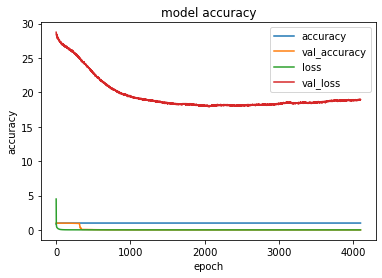

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [16]:
# 需要儲存article_id, 轉成dataframe
def predicting_txt_to_dataframe(path):    
    with open(path, 'r') as f:
        txt = str(f.read())
        txt_list = txt.split('\n')
    row_list = list()
    tmp_list = list()
    for row in txt_list:
        if row == '--------------------':
            tmp_list[0] = tmp_list[0].replace('article_id:', '')
            tmp_list[0] = int(tmp_list[0])
            row_list.append(tmp_list)
            tmp_list = list()
            continue
        if len(row) > 0:
            tmp_list.append(row)
    df = pd.DataFrame(row_list, columns=['article_id','text'])
    return df

In [17]:
def predict_NER(text):
    x_list = list()    
    text_list = re.split('\uff0c|\u3002|\uff1f', text)
    for article in text_list:
        x_list.append([i for i in article])
    y_list_list = model.predict(x_list)
    y_list = list()
    for sentence in y_list_list:
        for word in sentence:
            y_list.append(word)
        y_list.append('O') # append(，。？)
    y_list = y_list[:-1]
    return y_list

In [18]:
def output_NER(article_id, text, y_list):
    output_str = str()
    flag = False
    for i, j in enumerate(y_list):
        if j != 'O':
            if j[0] == 'B':
                start_position = i
                entity_type = j.split('-')[-1]
                flag = True
        elif j == 'O' and flag == True:
            end_position = i
            flag = False
            entity_text = text[start_position: end_position]
            entity = '{}\t{}\t{}\t{}\t{}\n'.format(article_id, start_position, end_position, entity_text, entity_type)  
            output_str += entity
    return output_str

In [19]:
df = predicting_txt_to_dataframe('/home/Danny/AI-CUP-2020/datasets/stage5/test.txt')
output_str = "article_id\tstart_position\tend_position\tentity_text\tentity_type\n"

for article_id, text in zip(df['article_id'], df['text']):
    x_list = [word for word in text]
    y_list = predict_NER(text)
    output_str += output_NER(article_id, text, y_list)

2020-12-16 11:49:37,687 [DEBUG] kashgari - predict seq_length: None, input: (2, 70, 17)


3/3 [==============================] - 0s 24ms/step


2020-12-16 11:49:41,661 [DEBUG] kashgari - predict output: (70, 17)
2020-12-16 11:49:41,662 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 0 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:49:41,665 [DEBUG] kashgari - predict seq_length: None, input: (2, 131, 28)


5/5 [==============================] - 0s 37ms/step


2020-12-16 11:49:46,143 [DEBUG] kashgari - predict output: (131, 28)
2020-12-16 11:49:46,144 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:49:46,148 [DEBUG] kashgari - predict seq_length: None, input: (2, 198, 47)


7/7 [==============================] - 0s 61ms/step


2020-12-16 11:49:50,635 [DEBUG] kashgari - predict output: (198, 47)
2020-12-16 11:49:50,636 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-16 11:49:50,638 [DEBUG] kashgari - predict seq_length: None, input: (2, 96, 41)


3/3 [==============================] - 0s 37ms/step


2020-12-16 11:49:53,553 [DEBUG] kashgari - predict output: (96, 41)
2020-12-16 11:49:53,554 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:49:53,556 [DEBUG] kashgari - predict seq_length: None, input: (2, 73, 17)


3/3 [==============================] - 0s 24ms/step


2020-12-16 11:49:53,696 [DEBUG] kashgari - predict output: (73, 17)
2020-12-16 11:49:53,697 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 9 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:49:53,702 [DEBUG] kashgari - predict seq_length: None, input: (2, 266, 23)


9/9 [==============================] - 0s 42ms/step


2020-12-16 11:49:58,069 [DEBUG] kashgari - predict output: (266, 23)
2020-12-16 11:49:58,070 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-16 11:49:58,077 [DEBUG] kashgari - predict seq_length: None, input: (2, 308, 21)


10/10 [==============================] - 0s 40ms/step


2020-12-16 11:50:02,409 [DEBUG] kashgari - predict output: (308, 21)
2020-12-16 11:50:02,410 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:50:02,413 [DEBUG] kashgari - predict seq_length: None, input: (2, 139, 38)


5/5 [==============================] - 0s 49ms/step


2020-12-16 11:50:06,763 [DEBUG] kashgari - predict output: (139, 38)
2020-12-16 11:50:06,764 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:50:06,767 [DEBUG] kashgari - predict seq_length: None, input: (2, 167, 22)


6/6 [==============================] - 0s 38ms/step


2020-12-16 11:50:11,043 [DEBUG] kashgari - predict output: (167, 22)
2020-12-16 11:50:11,044 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:50:11,049 [DEBUG] kashgari - predict seq_length: None, input: (2, 272, 41)


9/9 [==============================] - 1s 58ms/step


2020-12-16 11:50:15,577 [DEBUG] kashgari - predict output: (272, 41)
2020-12-16 11:50:15,578 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 7 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:50:15,581 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 63)


5/5 [==============================] - 0s 69ms/step


2020-12-16 11:50:19,923 [DEBUG] kashgari - predict output: (143, 63)
2020-12-16 11:50:19,924 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:50:19,933 [DEBUG] kashgari - predict seq_length: None, input: (2, 663, 42)


21/21 [==============================] - 1s 59ms/step


2020-12-16 11:50:25,267 [DEBUG] kashgari - predict output: (663, 42)
2020-12-16 11:50:25,268 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:50:25,271 [DEBUG] kashgari - predict seq_length: None, input: (2, 39, 25)


2/2 [==============================] - 0s 17ms/step


2020-12-16 11:50:30,732 [DEBUG] kashgari - predict output: (39, 25)
2020-12-16 11:50:30,735 [DEBUG] kashgari - predict output argmax: [[0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 0 1 1 1 

6/6 [==============================] - 0s 35ms/step


2020-12-16 11:50:31,023 [DEBUG] kashgari - predict output: (175, 22)
2020-12-16 11:50:31,024 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:50:31,027 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 28)


5/5 [==============================] - 0s 37ms/step


2020-12-16 11:50:31,299 [DEBUG] kashgari - predict output: (143, 28)
2020-12-16 11:50:31,300 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:50:31,303 [DEBUG] kashgari - predict seq_length: None, input: (2, 88, 21)


3/3 [==============================] - 0s 27ms/step


2020-12-16 11:50:31,452 [DEBUG] kashgari - predict output: (88, 21)
2020-12-16 11:50:31,453 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:50:31,457 [DEBUG] kashgari - predict seq_length: None, input: (2, 121, 28)


4/4 [==============================] - 0s 39ms/step


2020-12-16 11:50:31,691 [DEBUG] kashgari - predict output: (121, 28)
2020-12-16 11:50:31,692 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:50:31,695 [DEBUG] kashgari - predict seq_length: None, input: (2, 85, 27)


3/3 [==============================] - 0s 33ms/step


2020-12-16 11:50:35,711 [DEBUG] kashgari - predict output: (85, 27)
2020-12-16 11:50:35,712 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:50:35,718 [DEBUG] kashgari - predict seq_length: None, input: (2, 255, 19)


8/8 [==============================] - 0s 37ms/step


2020-12-16 11:50:40,063 [DEBUG] kashgari - predict output: (255, 19)
2020-12-16 11:50:40,064 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:50:40,068 [DEBUG] kashgari - predict seq_length: None, input: (2, 202, 29)


7/7 [==============================] - 0s 44ms/step


2020-12-16 11:50:44,518 [DEBUG] kashgari - predict output: (202, 29)
2020-12-16 11:50:44,519 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:50:44,524 [DEBUG] kashgari - predict seq_length: None, input: (2, 198, 19)


7/7 [==============================] - 0s 32ms/step


2020-12-16 11:50:44,822 [DEBUG] kashgari - predict output: (198, 19)
2020-12-16 11:50:44,823 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0 10  6 ...  6  6  6]
 [ 0  1  1 ...  6  6  6]
 [ 0  0  0 ...  0  0  0]]
2020-12-16 11:50:44,825 [DEBUG] kashgari - predict seq_length: None, input: (2, 102, 39)


4/4 [==============================] - 0s 45ms/step


2020-12-16 11:50:49,205 [DEBUG] kashgari - predict output: (102, 39)
2020-12-16 11:50:49,206 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:50:49,208 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 36)


3/3 [==============================] - 0s 34ms/step


2020-12-16 11:50:53,319 [DEBUG] kashgari - predict output: (72, 36)
2020-12-16 11:50:53,320 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:50:53,326 [DEBUG] kashgari - predict seq_length: None, input: (2, 246, 27)


8/8 [==============================] - 0s 44ms/step


2020-12-16 11:50:53,761 [DEBUG] kashgari - predict output: (246, 27)
2020-12-16 11:50:53,762 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:50:53,763 [DEBUG] kashgari - predict seq_length: None, input: (2, 57, 34)


2/2 [==============================] - 0s 30ms/step


2020-12-16 11:50:57,797 [DEBUG] kashgari - predict output: (57, 34)
2020-12-16 11:50:57,797 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:50:57,799 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 21)


3/3 [==============================] - 0s 28ms/step


2020-12-16 11:50:57,951 [DEBUG] kashgari - predict output: (82, 21)
2020-12-16 11:50:57,952 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:50:57,956 [DEBUG] kashgari - predict seq_length: None, input: (2, 185, 32)


6/6 [==============================] - 0s 45ms/step


2020-12-16 11:51:02,198 [DEBUG] kashgari - predict output: (185, 32)
2020-12-16 11:51:02,199 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:02,203 [DEBUG] kashgari - predict seq_length: None, input: (2, 148, 28)


5/5 [==============================] - 0s 38ms/step


2020-12-16 11:51:02,470 [DEBUG] kashgari - predict output: (148, 28)
2020-12-16 11:51:02,470 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:02,475 [DEBUG] kashgari - predict seq_length: None, input: (2, 281, 23)


9/9 [==============================] - 0s 40ms/step


2020-12-16 11:51:02,903 [DEBUG] kashgari - predict output: (281, 23)
2020-12-16 11:51:02,904 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:02,907 [DEBUG] kashgari - predict seq_length: None, input: (2, 116, 20)


4/4 [==============================] - 0s 31ms/step


2020-12-16 11:51:07,094 [DEBUG] kashgari - predict output: (116, 20)
2020-12-16 11:51:07,095 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:07,100 [DEBUG] kashgari - predict seq_length: None, input: (2, 168, 25)


6/6 [==============================] - 0s 41ms/step


2020-12-16 11:51:07,426 [DEBUG] kashgari - predict output: (168, 25)
2020-12-16 11:51:07,427 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 3 2 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:07,431 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 30)


7/7 [==============================] - 0s 49ms/step


2020-12-16 11:51:11,776 [DEBUG] kashgari - predict output: (218, 30)
2020-12-16 11:51:11,777 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:11,780 [DEBUG] kashgari - predict seq_length: None, input: (2, 123, 32)


4/4 [==============================] - 0s 42ms/step


2020-12-16 11:51:12,027 [DEBUG] kashgari - predict output: (123, 32)
2020-12-16 11:51:12,027 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:12,030 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 21)


3/3 [==============================] - 0s 25ms/step


2020-12-16 11:51:12,168 [DEBUG] kashgari - predict output: (82, 21)
2020-12-16 11:51:12,169 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 3 2 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:12,172 [DEBUG] kashgari - predict seq_length: None, input: (2, 95, 19)


3/3 [==============================] - 0s 26ms/step


2020-12-16 11:51:12,317 [DEBUG] kashgari - predict output: (95, 19)
2020-12-16 11:51:12,318 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:12,322 [DEBUG] kashgari - predict seq_length: None, input: (2, 245, 24)


8/8 [==============================] - 0s 43ms/step


2020-12-16 11:51:16,843 [DEBUG] kashgari - predict output: (245, 24)
2020-12-16 11:51:16,844 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 3 ... 5 5 5]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:16,847 [DEBUG] kashgari - predict seq_length: None, input: (2, 126, 31)


4/4 [==============================] - 0s 42ms/step


2020-12-16 11:51:21,017 [DEBUG] kashgari - predict output: (126, 31)
2020-12-16 11:51:21,018 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 7 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:21,020 [DEBUG] kashgari - predict seq_length: None, input: (2, 64, 19)


2/2 [==============================] - 0s 16ms/step


2020-12-16 11:51:24,069 [DEBUG] kashgari - predict output: (64, 19)
2020-12-16 11:51:24,070 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:24,072 [DEBUG] kashgari - predict seq_length: None, input: (2, 93, 24)


3/3 [==============================] - 0s 31ms/step


2020-12-16 11:51:24,236 [DEBUG] kashgari - predict output: (93, 24)
2020-12-16 11:51:24,237 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:24,241 [DEBUG] kashgari - predict seq_length: None, input: (2, 214, 16)


7/7 [==============================] - 0s 35ms/step


2020-12-16 11:51:28,393 [DEBUG] kashgari - predict output: (214, 16)
2020-12-16 11:51:28,394 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:28,396 [DEBUG] kashgari - predict seq_length: None, input: (2, 53, 20)


2/2 [==============================] - 0s 19ms/step


2020-12-16 11:51:28,503 [DEBUG] kashgari - predict output: (53, 20)
2020-12-16 11:51:28,504 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:28,512 [DEBUG] kashgari - predict seq_length: None, input: (2, 384, 18)


12/12 [==============================] - 0s 27ms/step


2020-12-16 11:51:31,756 [DEBUG] kashgari - predict output: (384, 18)
2020-12-16 11:51:31,757 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:31,760 [DEBUG] kashgari - predict seq_length: None, input: (2, 172, 24)


6/6 [==============================] - 0s 34ms/step


2020-12-16 11:51:32,032 [DEBUG] kashgari - predict output: (172, 24)
2020-12-16 11:51:32,033 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:32,037 [DEBUG] kashgari - predict seq_length: None, input: (2, 114, 24)


4/4 [==============================] - 0s 34ms/step


2020-12-16 11:51:32,244 [DEBUG] kashgari - predict output: (114, 24)
2020-12-16 11:51:32,245 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:32,248 [DEBUG] kashgari - predict seq_length: None, input: (2, 111, 47)


4/4 [==============================] - 0s 49ms/step


2020-12-16 11:51:32,540 [DEBUG] kashgari - predict output: (111, 47)
2020-12-16 11:51:32,541 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:32,547 [DEBUG] kashgari - predict seq_length: None, input: (2, 350, 34)


11/11 [==============================] - 1s 50ms/step


2020-12-16 11:51:33,182 [DEBUG] kashgari - predict output: (350, 34)
2020-12-16 11:51:33,184 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ... 14 14 14]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-16 11:51:33,186 [DEBUG] kashgari - predict seq_length: None, input: (2, 56, 20)


2/2 [==============================] - 0s 19ms/step


2020-12-16 11:51:33,284 [DEBUG] kashgari - predict output: (56, 20)
2020-12-16 11:51:33,285 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:33,289 [DEBUG] kashgari - predict seq_length: None, input: (2, 131, 17)


5/5 [==============================] - 0s 28ms/step


2020-12-16 11:51:33,493 [DEBUG] kashgari - predict output: (131, 17)
2020-12-16 11:51:33,494 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:33,498 [DEBUG] kashgari - predict seq_length: None, input: (2, 184, 34)


6/6 [==============================] - 0s 45ms/step


2020-12-16 11:51:33,849 [DEBUG] kashgari - predict output: (184, 34)
2020-12-16 11:51:33,850 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:33,853 [DEBUG] kashgari - predict seq_length: None, input: (2, 133, 51)


5/5 [==============================] - 0s 56ms/step


2020-12-16 11:51:38,163 [DEBUG] kashgari - predict output: (133, 51)
2020-12-16 11:51:38,164 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 9 5 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:38,168 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 53)


7/7 [==============================] - 0s 69ms/step


2020-12-16 11:51:44,921 [DEBUG] kashgari - predict output: (210, 53)
2020-12-16 11:51:44,922 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 5 5 5]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:44,925 [DEBUG] kashgari - predict seq_length: None, input: (2, 193, 55)


7/7 [==============================] - 0s 63ms/step


2020-12-16 11:51:49,345 [DEBUG] kashgari - predict output: (193, 55)
2020-12-16 11:51:49,346 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  9  5 ... 14 14 14]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-16 11:51:49,348 [DEBUG] kashgari - predict seq_length: None, input: (2, 75, 30)


3/3 [==============================] - 0s 30ms/step


2020-12-16 11:51:49,512 [DEBUG] kashgari - predict output: (75, 30)
2020-12-16 11:51:49,513 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:49,518 [DEBUG] kashgari - predict seq_length: None, input: (2, 280, 46)


9/9 [==============================] - 1s 64ms/step


2020-12-16 11:51:54,082 [DEBUG] kashgari - predict output: (280, 46)
2020-12-16 11:51:54,083 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:54,086 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 20)


7/7 [==============================] - 0s 34ms/step


2020-12-16 11:51:54,394 [DEBUG] kashgari - predict output: (210, 20)
2020-12-16 11:51:54,395 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:54,398 [DEBUG] kashgari - predict seq_length: None, input: (2, 176, 24)


6/6 [==============================] - 0s 35ms/step


2020-12-16 11:51:54,675 [DEBUG] kashgari - predict output: (176, 24)
2020-12-16 11:51:54,676 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:54,680 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 25)


7/7 [==============================] - 0s 41ms/step


2020-12-16 11:51:55,037 [DEBUG] kashgari - predict output: (218, 25)
2020-12-16 11:51:55,038 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:55,041 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 23)


3/3 [==============================] - 0s 29ms/step


2020-12-16 11:51:55,203 [DEBUG] kashgari - predict output: (91, 23)
2020-12-16 11:51:55,204 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:55,209 [DEBUG] kashgari - predict seq_length: None, input: (2, 194, 28)


7/7 [==============================] - 0s 39ms/step


2020-12-16 11:51:55,564 [DEBUG] kashgari - predict output: (194, 28)
2020-12-16 11:51:55,565 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 ...
 [0 3 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:55,569 [DEBUG] kashgari - predict seq_length: None, input: (2, 179, 23)


6/6 [==============================] - 0s 38ms/step


2020-12-16 11:51:55,866 [DEBUG] kashgari - predict output: (179, 23)
2020-12-16 11:51:55,867 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:51:55,872 [DEBUG] kashgari - predict seq_length: None, input: (2, 234, 40)


8/8 [==============================] - 0s 54ms/step


2020-12-16 11:52:00,251 [DEBUG] kashgari - predict output: (234, 40)
2020-12-16 11:52:00,252 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:00,256 [DEBUG] kashgari - predict seq_length: None, input: (2, 250, 26)


8/8 [==============================] - 0s 43ms/step


2020-12-16 11:52:04,520 [DEBUG] kashgari - predict output: (250, 26)
2020-12-16 11:52:04,521 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:04,525 [DEBUG] kashgari - predict seq_length: None, input: (2, 170, 43)


6/6 [==============================] - 0s 53ms/step


2020-12-16 11:52:08,750 [DEBUG] kashgari - predict output: (170, 43)
2020-12-16 11:52:08,751 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:08,754 [DEBUG] kashgari - predict seq_length: None, input: (2, 145, 34)


5/5 [==============================] - 0s 40ms/step


2020-12-16 11:52:09,042 [DEBUG] kashgari - predict output: (145, 34)
2020-12-16 11:52:09,043 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 3 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:09,046 [DEBUG] kashgari - predict seq_length: None, input: (2, 102, 29)


4/4 [==============================] - 0s 34ms/step


2020-12-16 11:52:09,256 [DEBUG] kashgari - predict output: (102, 29)
2020-12-16 11:52:09,257 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:09,262 [DEBUG] kashgari - predict seq_length: None, input: (2, 340, 20)


11/11 [==============================] - 0s 35ms/step


2020-12-16 11:52:09,717 [DEBUG] kashgari - predict output: (340, 20)
2020-12-16 11:52:09,718 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:09,722 [DEBUG] kashgari - predict seq_length: None, input: (2, 122, 23)


4/4 [==============================] - 0s 32ms/step


2020-12-16 11:52:09,924 [DEBUG] kashgari - predict output: (122, 23)
2020-12-16 11:52:09,925 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 3 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:09,932 [DEBUG] kashgari - predict seq_length: None, input: (2, 381, 28)


12/12 [==============================] - 1s 43ms/step


2020-12-16 11:52:10,523 [DEBUG] kashgari - predict output: (381, 28)
2020-12-16 11:52:10,525 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:10,529 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 27)


8/8 [==============================] - 0s 41ms/step


2020-12-16 11:52:10,925 [DEBUG] kashgari - predict output: (244, 27)
2020-12-16 11:52:10,926 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:10,929 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 46)


3/3 [==============================] - 0s 49ms/step


2020-12-16 11:52:11,172 [DEBUG] kashgari - predict output: (91, 46)
2020-12-16 11:52:11,173 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:11,178 [DEBUG] kashgari - predict seq_length: None, input: (2, 223, 42)


7/7 [==============================] - 0s 51ms/step


2020-12-16 11:52:11,625 [DEBUG] kashgari - predict output: (223, 42)
2020-12-16 11:52:11,627 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:11,631 [DEBUG] kashgari - predict seq_length: None, input: (2, 146, 25)


5/5 [==============================] - 0s 35ms/step


2020-12-16 11:52:11,879 [DEBUG] kashgari - predict output: (146, 25)
2020-12-16 11:52:11,879 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:11,883 [DEBUG] kashgari - predict seq_length: None, input: (2, 162, 23)


6/6 [==============================] - 0s 37ms/step


2020-12-16 11:52:12,175 [DEBUG] kashgari - predict output: (162, 23)
2020-12-16 11:52:12,175 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:12,179 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 27)


8/8 [==============================] - 0s 39ms/step


2020-12-16 11:52:12,571 [DEBUG] kashgari - predict output: (244, 27)
2020-12-16 11:52:12,572 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 9 5 ... 5 5 5]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:12,576 [DEBUG] kashgari - predict seq_length: None, input: (2, 170, 18)


6/6 [==============================] - 0s 31ms/step


2020-12-16 11:52:16,691 [DEBUG] kashgari - predict output: (170, 18)
2020-12-16 11:52:16,692 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 0 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:16,696 [DEBUG] kashgari - predict seq_length: None, input: (2, 199, 36)


7/7 [==============================] - 0s 49ms/step


2020-12-16 11:52:17,130 [DEBUG] kashgari - predict output: (199, 36)
2020-12-16 11:52:17,131 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:17,138 [DEBUG] kashgari - predict seq_length: None, input: (2, 557, 17)


18/18 [==============================] - 1s 35ms/step


2020-12-16 11:52:17,833 [DEBUG] kashgari - predict output: (557, 17)
2020-12-16 11:52:17,837 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 9 5 ... 5 5 5]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:17,843 [DEBUG] kashgari - predict seq_length: None, input: (2, 278, 42)


9/9 [==============================] - 0s 55ms/step


2020-12-16 11:52:18,433 [DEBUG] kashgari - predict output: (278, 42)
2020-12-16 11:52:18,435 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:18,437 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 19)


3/3 [==============================] - 0s 26ms/step


2020-12-16 11:52:18,577 [DEBUG] kashgari - predict output: (91, 19)
2020-12-16 11:52:18,577 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:18,582 [DEBUG] kashgari - predict seq_length: None, input: (2, 296, 24)


10/10 [==============================] - 0s 38ms/step


2020-12-16 11:52:19,037 [DEBUG] kashgari - predict output: (296, 24)
2020-12-16 11:52:19,038 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:19,041 [DEBUG] kashgari - predict seq_length: None, input: (2, 154, 48)


5/5 [==============================] - 0s 59ms/step


2020-12-16 11:52:23,565 [DEBUG] kashgari - predict output: (154, 48)
2020-12-16 11:52:23,566 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:23,569 [DEBUG] kashgari - predict seq_length: None, input: (2, 206, 37)


7/7 [==============================] - 0s 47ms/step


2020-12-16 11:52:27,873 [DEBUG] kashgari - predict output: (206, 37)
2020-12-16 11:52:27,873 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 9 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:27,877 [DEBUG] kashgari - predict seq_length: None, input: (2, 241, 20)


8/8 [==============================] - 0s 33ms/step


2020-12-16 11:52:28,208 [DEBUG] kashgari - predict output: (241, 20)
2020-12-16 11:52:28,209 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 3 2 ... 2 2 2]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:28,216 [DEBUG] kashgari - predict seq_length: None, input: (2, 459, 31)


15/15 [==============================] - 1s 48ms/step


2020-12-16 11:52:29,017 [DEBUG] kashgari - predict output: (459, 31)
2020-12-16 11:52:29,018 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:29,022 [DEBUG] kashgari - predict seq_length: None, input: (2, 223, 34)


7/7 [==============================] - 0s 47ms/step


2020-12-16 11:52:29,433 [DEBUG] kashgari - predict output: (223, 34)
2020-12-16 11:52:29,433 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:29,438 [DEBUG] kashgari - predict seq_length: None, input: (2, 358, 26)


12/12 [==============================] - 1s 42ms/step


2020-12-16 11:52:30,024 [DEBUG] kashgari - predict output: (358, 26)
2020-12-16 11:52:30,026 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:30,028 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 20)


3/3 [==============================] - 0s 24ms/step


2020-12-16 11:52:30,163 [DEBUG] kashgari - predict output: (72, 20)
2020-12-16 11:52:30,164 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:30,167 [DEBUG] kashgari - predict seq_length: None, input: (2, 75, 24)


3/3 [==============================] - 0s 26ms/step


2020-12-16 11:52:30,317 [DEBUG] kashgari - predict output: (75, 24)
2020-12-16 11:52:30,317 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:30,321 [DEBUG] kashgari - predict seq_length: None, input: (2, 191, 36)


6/6 [==============================] - 0s 47ms/step


2020-12-16 11:52:30,695 [DEBUG] kashgari - predict output: (191, 36)
2020-12-16 11:52:30,696 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:30,699 [DEBUG] kashgari - predict seq_length: None, input: (2, 149, 19)


5/5 [==============================] - 0s 32ms/step


2020-12-16 11:52:30,931 [DEBUG] kashgari - predict output: (149, 19)
2020-12-16 11:52:30,932 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:30,937 [DEBUG] kashgari - predict seq_length: None, input: (2, 176, 22)


6/6 [==============================] - 0s 33ms/step


2020-12-16 11:52:31,198 [DEBUG] kashgari - predict output: (176, 22)
2020-12-16 11:52:31,199 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 7 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:31,203 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 45)


4/4 [==============================] - 0s 52ms/step


2020-12-16 11:52:35,514 [DEBUG] kashgari - predict output: (112, 45)
2020-12-16 11:52:35,515 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:35,519 [DEBUG] kashgari - predict seq_length: None, input: (2, 269, 21)


9/9 [==============================] - 0s 38ms/step


2020-12-16 11:52:35,938 [DEBUG] kashgari - predict output: (269, 21)
2020-12-16 11:52:35,939 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:35,942 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 18)


4/4 [==============================] - 0s 28ms/step


2020-12-16 11:52:36,120 [DEBUG] kashgari - predict output: (112, 18)
2020-12-16 11:52:36,121 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 7 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:36,126 [DEBUG] kashgari - predict seq_length: None, input: (2, 352, 22)


11/11 [==============================] - 0s 31ms/step


2020-12-16 11:52:39,445 [DEBUG] kashgari - predict output: (352, 22)
2020-12-16 11:52:39,446 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:39,450 [DEBUG] kashgari - predict seq_length: None, input: (2, 243, 24)


8/8 [==============================] - 0s 36ms/step


2020-12-16 11:52:39,817 [DEBUG] kashgari - predict output: (243, 24)
2020-12-16 11:52:39,818 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:39,824 [DEBUG] kashgari - predict seq_length: None, input: (2, 340, 27)


11/11 [==============================] - 0s 42ms/step


2020-12-16 11:52:40,365 [DEBUG] kashgari - predict output: (340, 27)
2020-12-16 11:52:40,366 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:40,371 [DEBUG] kashgari - predict seq_length: None, input: (2, 384, 25)


12/12 [==============================] - 0s 33ms/step


2020-12-16 11:52:43,814 [DEBUG] kashgari - predict output: (384, 25)
2020-12-16 11:52:43,815 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:43,819 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 36)


4/4 [==============================] - 0s 40ms/step


2020-12-16 11:52:44,069 [DEBUG] kashgari - predict output: (112, 36)
2020-12-16 11:52:44,070 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:44,074 [DEBUG] kashgari - predict seq_length: None, input: (2, 222, 28)


7/7 [==============================] - 0s 42ms/step


2020-12-16 11:52:44,443 [DEBUG] kashgari - predict output: (222, 28)
2020-12-16 11:52:44,444 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:44,449 [DEBUG] kashgari - predict seq_length: None, input: (2, 255, 34)


8/8 [==============================] - 0s 48ms/step


2020-12-16 11:52:44,917 [DEBUG] kashgari - predict output: (255, 34)
2020-12-16 11:52:44,918 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:44,919 [DEBUG] kashgari - predict seq_length: None, input: (2, 67, 25)


3/3 [==============================] - 0s 27ms/step


2020-12-16 11:52:45,071 [DEBUG] kashgari - predict output: (67, 25)
2020-12-16 11:52:45,072 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:45,075 [DEBUG] kashgari - predict seq_length: None, input: (2, 77, 53)


3/3 [==============================] - 0s 46ms/step


2020-12-16 11:52:45,321 [DEBUG] kashgari - predict output: (77, 53)
2020-12-16 11:52:45,322 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:45,324 [DEBUG] kashgari - predict seq_length: None, input: (2, 67, 27)


3/3 [==============================] - 0s 26ms/step


2020-12-16 11:52:45,475 [DEBUG] kashgari - predict output: (67, 27)
2020-12-16 11:52:45,476 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:45,478 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 19)


3/3 [==============================] - 0s 24ms/step


2020-12-16 11:52:45,614 [DEBUG] kashgari - predict output: (72, 19)
2020-12-16 11:52:45,614 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:45,617 [DEBUG] kashgari - predict seq_length: None, input: (2, 98, 24)


4/4 [==============================] - 0s 33ms/step


2020-12-16 11:52:45,818 [DEBUG] kashgari - predict output: (98, 24)
2020-12-16 11:52:45,819 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:45,822 [DEBUG] kashgari - predict seq_length: None, input: (2, 87, 37)


3/3 [==============================] - 0s 35ms/step


2020-12-16 11:52:46,009 [DEBUG] kashgari - predict output: (87, 37)
2020-12-16 11:52:46,010 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:46,021 [DEBUG] kashgari - predict seq_length: None, input: (2, 311, 29)


10/10 [==============================] - 0s 45ms/step


2020-12-16 11:52:46,550 [DEBUG] kashgari - predict output: (311, 29)
2020-12-16 11:52:46,551 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:46,556 [DEBUG] kashgari - predict seq_length: None, input: (2, 447, 20)


14/14 [==============================] - 1s 37ms/step


2020-12-16 11:52:47,148 [DEBUG] kashgari - predict output: (447, 20)
2020-12-16 11:52:47,149 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:47,154 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 19)


7/7 [==============================] - 0s 33ms/step


2020-12-16 11:52:47,459 [DEBUG] kashgari - predict output: (218, 19)
2020-12-16 11:52:47,459 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:47,463 [DEBUG] kashgari - predict seq_length: None, input: (2, 285, 30)


9/9 [==============================] - 0s 45ms/step


2020-12-16 11:52:47,944 [DEBUG] kashgari - predict output: (285, 30)
2020-12-16 11:52:47,945 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 4]
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:47,950 [DEBUG] kashgari - predict seq_length: None, input: (2, 424, 21)


14/14 [==============================] - 1s 37ms/step


2020-12-16 11:52:48,545 [DEBUG] kashgari - predict output: (424, 21)
2020-12-16 11:52:48,546 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:48,548 [DEBUG] kashgari - predict seq_length: None, input: (2, 94, 30)


3/3 [==============================] - 0s 33ms/step


2020-12-16 11:52:48,727 [DEBUG] kashgari - predict output: (94, 30)
2020-12-16 11:52:48,728 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:48,733 [DEBUG] kashgari - predict seq_length: None, input: (2, 202, 34)


7/7 [==============================] - 0s 46ms/step


2020-12-16 11:52:49,139 [DEBUG] kashgari - predict output: (202, 34)
2020-12-16 11:52:49,140 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:49,144 [DEBUG] kashgari - predict seq_length: None, input: (2, 242, 50)


8/8 [==============================] - 1s 66ms/step


2020-12-16 11:52:53,746 [DEBUG] kashgari - predict output: (242, 50)
2020-12-16 11:52:53,747 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-16 11:52:53,750 [DEBUG] kashgari - predict seq_length: None, input: (2, 269, 38)


9/9 [==============================] - 0s 51ms/step


2020-12-16 11:52:54,299 [DEBUG] kashgari - predict output: (269, 38)
2020-12-16 11:52:54,301 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:54,303 [DEBUG] kashgari - predict seq_length: None, input: (2, 108, 35)


4/4 [==============================] - 0s 39ms/step


2020-12-16 11:52:58,427 [DEBUG] kashgari - predict output: (108, 35)
2020-12-16 11:52:58,428 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:58,431 [DEBUG] kashgari - predict seq_length: None, input: (2, 136, 30)


5/5 [==============================] - 0s 40ms/step


2020-12-16 11:52:58,711 [DEBUG] kashgari - predict output: (136, 30)
2020-12-16 11:52:58,711 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:58,715 [DEBUG] kashgari - predict seq_length: None, input: (2, 217, 28)


7/7 [==============================] - 0s 39ms/step


2020-12-16 11:52:59,063 [DEBUG] kashgari - predict output: (217, 28)
2020-12-16 11:52:59,065 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:59,067 [DEBUG] kashgari - predict seq_length: None, input: (2, 83, 27)


3/3 [==============================] - 0s 30ms/step


2020-12-16 11:52:59,232 [DEBUG] kashgari - predict output: (83, 27)
2020-12-16 11:52:59,233 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:52:59,240 [DEBUG] kashgari - predict seq_length: None, input: (2, 392, 36)


13/13 [==============================] - 1s 51ms/step


2020-12-16 11:53:00,000 [DEBUG] kashgari - predict output: (392, 36)
2020-12-16 11:53:00,001 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:00,003 [DEBUG] kashgari - predict seq_length: None, input: (2, 108, 41)


4/4 [==============================] - 0s 43ms/step


2020-12-16 11:53:00,266 [DEBUG] kashgari - predict output: (108, 41)
2020-12-16 11:53:00,267 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:00,272 [DEBUG] kashgari - predict seq_length: None, input: (2, 221, 26)


7/7 [==============================] - 0s 41ms/step


2020-12-16 11:53:00,631 [DEBUG] kashgari - predict output: (221, 26)
2020-12-16 11:53:00,632 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:00,635 [DEBUG] kashgari - predict seq_length: None, input: (2, 94, 45)


3/3 [==============================] - 0s 43ms/step


2020-12-16 11:53:00,866 [DEBUG] kashgari - predict output: (94, 45)
2020-12-16 11:53:00,867 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:00,869 [DEBUG] kashgari - predict seq_length: None, input: (2, 59, 21)


2/2 [==============================] - 0s 20ms/step


2020-12-16 11:53:00,971 [DEBUG] kashgari - predict output: (59, 21)
2020-12-16 11:53:00,972 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:00,976 [DEBUG] kashgari - predict seq_length: None, input: (2, 101, 33)


4/4 [==============================] - 0s 39ms/step


2020-12-16 11:53:05,231 [DEBUG] kashgari - predict output: (101, 33)
2020-12-16 11:53:05,232 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:05,234 [DEBUG] kashgari - predict seq_length: None, input: (2, 64, 33)


2/2 [==============================] - 0s 24ms/step


2020-12-16 11:53:08,139 [DEBUG] kashgari - predict output: (64, 33)
2020-12-16 11:53:08,140 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:08,142 [DEBUG] kashgari - predict seq_length: None, input: (2, 85, 30)


3/3 [==============================] - 0s 35ms/step


2020-12-16 11:53:08,329 [DEBUG] kashgari - predict output: (85, 30)
2020-12-16 11:53:08,330 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:08,333 [DEBUG] kashgari - predict seq_length: None, input: (2, 89, 33)


3/3 [==============================] - 0s 39ms/step


2020-12-16 11:53:08,535 [DEBUG] kashgari - predict output: (89, 33)
2020-12-16 11:53:08,536 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:08,542 [DEBUG] kashgari - predict seq_length: None, input: (2, 254, 27)


8/8 [==============================] - 0s 45ms/step


2020-12-16 11:53:08,978 [DEBUG] kashgari - predict output: (254, 27)
2020-12-16 11:53:08,979 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:08,983 [DEBUG] kashgari - predict seq_length: None, input: (2, 129, 29)


5/5 [==============================] - 0s 38ms/step


2020-12-16 11:53:09,249 [DEBUG] kashgari - predict output: (129, 29)
2020-12-16 11:53:09,250 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:09,253 [DEBUG] kashgari - predict seq_length: None, input: (2, 130, 26)


5/5 [==============================] - 0s 33ms/step


2020-12-16 11:53:09,493 [DEBUG] kashgari - predict output: (130, 26)
2020-12-16 11:53:09,494 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:09,498 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 37)


5/5 [==============================] - 0s 46ms/step


2020-12-16 11:53:09,809 [DEBUG] kashgari - predict output: (143, 37)
2020-12-16 11:53:09,810 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:09,813 [DEBUG] kashgari - predict seq_length: None, input: (2, 107, 36)


4/4 [==============================] - 0s 39ms/step


2020-12-16 11:53:10,054 [DEBUG] kashgari - predict output: (107, 36)
2020-12-16 11:53:10,054 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:10,057 [DEBUG] kashgari - predict seq_length: None, input: (2, 70, 28)


3/3 [==============================] - 0s 31ms/step


2020-12-16 11:53:10,220 [DEBUG] kashgari - predict output: (70, 28)
2020-12-16 11:53:10,221 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:10,224 [DEBUG] kashgari - predict seq_length: None, input: (2, 189, 26)


6/6 [==============================] - 0s 38ms/step


2020-12-16 11:53:10,525 [DEBUG] kashgari - predict output: (189, 26)
2020-12-16 11:53:10,526 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:10,529 [DEBUG] kashgari - predict seq_length: None, input: (2, 99, 48)


4/4 [==============================] - 0s 48ms/step


2020-12-16 11:53:10,814 [DEBUG] kashgari - predict output: (99, 48)
2020-12-16 11:53:10,815 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:10,819 [DEBUG] kashgari - predict seq_length: None, input: (2, 213, 35)


7/7 [==============================] - 0s 48ms/step


2020-12-16 11:53:11,241 [DEBUG] kashgari - predict output: (213, 35)
2020-12-16 11:53:11,242 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:11,246 [DEBUG] kashgari - predict seq_length: None, input: (2, 181, 40)


6/6 [==============================] - 0s 49ms/step


2020-12-16 11:53:11,627 [DEBUG] kashgari - predict output: (181, 40)
2020-12-16 11:53:11,628 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:11,631 [DEBUG] kashgari - predict seq_length: None, input: (2, 119, 34)


4/4 [==============================] - 0s 38ms/step


2020-12-16 11:53:11,872 [DEBUG] kashgari - predict output: (119, 34)
2020-12-16 11:53:11,873 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:11,876 [DEBUG] kashgari - predict seq_length: None, input: (2, 188, 52)


6/6 [==============================] - 0s 69ms/step


2020-12-16 11:53:16,278 [DEBUG] kashgari - predict output: (188, 52)
2020-12-16 11:53:16,280 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:16,286 [DEBUG] kashgari - predict seq_length: None, input: (2, 252, 30)


8/8 [==============================] - 0s 44ms/step


2020-12-16 11:53:16,716 [DEBUG] kashgari - predict output: (252, 30)
2020-12-16 11:53:16,718 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:16,724 [DEBUG] kashgari - predict seq_length: None, input: (2, 249, 38)


8/8 [==============================] - 0s 51ms/step


2020-12-16 11:53:17,221 [DEBUG] kashgari - predict output: (249, 38)
2020-12-16 11:53:17,222 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1 17 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-16 11:53:17,224 [DEBUG] kashgari - predict seq_length: None, input: (2, 65, 44)


3/3 [==============================] - 0s 39ms/step


2020-12-16 11:53:21,268 [DEBUG] kashgari - predict output: (65, 44)
2020-12-16 11:53:21,269 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ... 11 11 11]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-16 11:53:21,274 [DEBUG] kashgari - predict seq_length: None, input: (2, 265, 41)


9/9 [==============================] - 1s 58ms/step


2020-12-16 11:53:21,897 [DEBUG] kashgari - predict output: (265, 41)
2020-12-16 11:53:21,898 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:21,901 [DEBUG] kashgari - predict seq_length: None, input: (2, 163, 33)


6/6 [==============================] - 0s 42ms/step


2020-12-16 11:53:22,238 [DEBUG] kashgari - predict output: (163, 33)
2020-12-16 11:53:22,238 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 2 2 2]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:22,241 [DEBUG] kashgari - predict seq_length: None, input: (2, 166, 33)


6/6 [==============================] - 0s 42ms/step


2020-12-16 11:53:22,574 [DEBUG] kashgari - predict output: (166, 33)
2020-12-16 11:53:22,575 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 7 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:22,578 [DEBUG] kashgari - predict seq_length: None, input: (2, 152, 37)


5/5 [==============================] - 0s 47ms/step


2020-12-16 11:53:22,899 [DEBUG] kashgari - predict output: (152, 37)
2020-12-16 11:53:22,900 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:22,903 [DEBUG] kashgari - predict seq_length: None, input: (2, 129, 26)


5/5 [==============================] - 0s 35ms/step


2020-12-16 11:53:23,151 [DEBUG] kashgari - predict output: (129, 26)
2020-12-16 11:53:23,152 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:23,157 [DEBUG] kashgari - predict seq_length: None, input: (2, 260, 42)


9/9 [==============================] - 0s 54ms/step


2020-12-16 11:53:23,755 [DEBUG] kashgari - predict output: (260, 42)
2020-12-16 11:53:23,756 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:23,765 [DEBUG] kashgari - predict seq_length: None, input: (2, 557, 59)


18/18 [==============================] - 1s 79ms/step


2020-12-16 11:53:29,412 [DEBUG] kashgari - predict output: (557, 59)
2020-12-16 11:53:29,413 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ... 14 14 14]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-16 11:53:29,417 [DEBUG] kashgari - predict seq_length: None, input: (2, 144, 72)


5/5 [==============================] - 0s 76ms/step


2020-12-16 11:53:36,665 [DEBUG] kashgari - predict output: (144, 72)
2020-12-16 11:53:36,666 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:36,671 [DEBUG] kashgari - predict seq_length: None, input: (2, 474, 27)


15/15 [==============================] - 1s 44ms/step


2020-12-16 11:53:37,411 [DEBUG] kashgari - predict output: (474, 27)
2020-12-16 11:53:37,412 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:37,416 [DEBUG] kashgari - predict seq_length: None, input: (2, 253, 34)


8/8 [==============================] - 0s 48ms/step


2020-12-16 11:53:37,882 [DEBUG] kashgari - predict output: (253, 34)
2020-12-16 11:53:37,883 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:37,887 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 45)


7/7 [==============================] - 0s 59ms/step


2020-12-16 11:53:38,398 [DEBUG] kashgari - predict output: (210, 45)
2020-12-16 11:53:38,399 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:38,402 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 32)


8/8 [==============================] - 0s 46ms/step


2020-12-16 11:53:38,853 [DEBUG] kashgari - predict output: (244, 32)
2020-12-16 11:53:38,854 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:38,860 [DEBUG] kashgari - predict seq_length: None, input: (2, 319, 36)


10/10 [==============================] - 1s 52ms/step


2020-12-16 11:53:39,466 [DEBUG] kashgari - predict output: (319, 36)
2020-12-16 11:53:39,467 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:39,472 [DEBUG] kashgari - predict seq_length: None, input: (2, 437, 36)


14/14 [==============================] - 1s 52ms/step


2020-12-16 11:53:40,298 [DEBUG] kashgari - predict output: (437, 36)
2020-12-16 11:53:40,299 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-16 11:53:40,302 [DEBUG] kashgari - predict seq_length: None, input: (2, 171, 78)


6/6 [==============================] - 1s 86ms/step


2020-12-16 11:53:44,850 [DEBUG] kashgari - predict output: (171, 78)
2020-12-16 11:53:44,850 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]


In [20]:
output_path = 'output/{}_epoch_{}_batch_{}.tsv'.format(model_name, epochs, batch_size)
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(output_str)

In [21]:
df = pd.read_csv(output_path, sep='\t')
df

,article_id,start_position,end_position,entity_text,entity_type
0,0,113,115,今天,time
1,0,198,200,新樓,location
2,0,227,229,麻豆,location
3,0,237,239,麻豆,location
4,1,31,33,今天,time
...,...,...,...,...,...
2701,158,1074,1076,今天,time
2702,158,1082,1086,第三個月,time
2703,158,1143,1145,今天,time
2704,158,1199,1201,小安,name
